# Install Dependencies

In [ ]:
!pip install scikit-learn==1.2.2 lightgbm==3.3.5 numpy==1.22.4 pandas==1.5.3 joblib==1.2.0 seaborn==0.12.2 Flask==2.3.1 discord==2.2.2 flask-ngrok2==0.2.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import Packages

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score, fbeta_score, make_scorer, confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

# Context

Many individuals face difficulties in obtaining loans due to inadequate or non-existent credit histories, and this group is often exploited by unscrupulous lenders. A particular bank seeks to improve financial inclusion for the unbanked population by offering a secure and positive borrowing experience.

To ensure a positive loan experience for this underserved group, the bank utilizes a range of alternative data sources, such as telecommunications and transactional information, to assess their clients' ability to repay loans. Although the bank is currently employing various statistical and machine learning techniques to make these predictions, they are challenging you to fully harness the potential of their data and create a ML service for real time default prediction of loan applications.

By doing so, you can help the bank avoid rejecting clients capable of repayment, as well as identify clients who are likely to default. This will enable the bank to provide loans with suitable principal amounts, maturities, and repayment schedules that empower their clients to succeed while minimizing risks associated with loan defaults.

## Content & Explanation
### Attribute Information of [train.csv](https://miles-become-a-data-scientist.s3.us-east-2.amazonaws.com/J3/M3/data/train.csv): 		

- `SK_ID_CURR`: ID of the loan
- `AMT_ANNUITY`: Loan annuity
- `AMT_CREDIT`: Credit amount of the loan
- `AMT_GOODS_PRICE`: For consumer loans it is the price of the goods for which the loan is given
- `AMT_INCOME_TOTAL`: Income of the client
- `CNT_CHILDREN`: Number of children the client has
- `CNT_FAM_MEMBERS`: How many family members does the client have
- `CODE_GENDER`: Gender of the client
- `DAYS_BIRTH`: Client's age in days at the time of application
- `DAYS_EMPLOYED`: How many days before the application the person started current employment
- `DAYS_ID_PUBLISH`: How many days before the application did the client change the identity document with which he applied for the loan
- `DAYS_LAST_PHONE_CHANGE`: How many days before application did the client change phone
- `DAYS_REGISTRATION`: How many days before the application did the client change his registration
- `FLAG_EMAIL`: Did the client provide email (1=YES, 0=NO)
- `FLAG_MOBIL`: Did the client provide mobile phone (1=YES, 0=NO)
- `FLAG_OWN_CAR`: Flag if the client owns a car
- `FLAG_OWN_REALTY`: Flag if the client owns a house or flat
- `FLAG_PHONE`: Did the client provide home phone (1=YES, 0=NO)
- `FLAG_WORK_PHONE`: Did the client provide home phone (1=YES, 0=NO)
- `NAME_EDUCATION_TYPE`: Level of highest education the client achieved
- `NAME_FAMILY_STATUS`: Family status of the client
- `NAME_HOUSING_TYPE`: What is the housing situation of the client (renting, living with parents, ...)
- `NAME_INCOME_TYPE`: Clients income type (businessman, working, maternity leave, etc.)
- `OCCUPATION_TYPE`: What kind of occupation does the client have
- `OWN_CAR_AGE`: Age of the client's car
- `TARGET`: Target variable (1 - Default, 0 - Repay)

### Cost Matrix

The bank shared that this is their estimated cost matrix for optimizing their default prediction probability threshold:

|        | **Predicted (TARGET)** |           |
|--------|---------------|-----------|
|        | Repay (0)        | Default (1)   |
| **Actual (TARGET)** |               |           |
| Repay (0)  | $0$           | $ - 0.25 \times AMT\_CREDIT$       |
| Default (1) | $-1 \times AMT\_CREDIT$           | $0$       |

Where:
* True Negative: $0$
  
  * When the model correctly predicts that a client will repay the loan, there is no cost associated with this outcome.
* True Positive: $0$ 

  * When the model correctly predicts that a client will default, there is no cost associated with this outcome.
* False Positive: $ - 0.25 \times AMT\_CREDIT$ 

  * When the model incorrectly predicts that a client will default, the bank may lose potential profit from interest payments. Assuming the bank would have gained around 25% of the loan amount as profit, the cost for this error is set to  $ - 0.25 \times AMT\_CREDIT$.
* False Negative: $-1 \times AMT\_CREDIT$ 

  * When the model incorrectly predicts that a client will repay the loan, the bank risks losing the entire loan amount. Therefore, the cost for this error is set to $-1 \times AMT\_CREDIT$.

# Tasks

Always start by taking a look at the dataset, getting familiar with the variables and check any data issues, before diving into the problem.

## 1. Preparing your Machine Learning Pipeline

In this task, you will design and implement a complete machine learning pipeline for loan default prediction. The pipeline will involve data preprocessing, feature engineering, model selection, hyperparameter tuning, model evaluation, and probability threshold optimization.

We suggest that you first complete this Activity with a simple solution and continue with the deployment. Once the deployment is done, you can return to this activity and develop a better solution to re-deploy again.

Some important topics to analyse:
* The dataset shape
* The first rows of the dataset
* The dataset summary statistics
* Missing values
* Target label distribution
* Feature distributions


### 1.1 Load and Analyse the Dataset

Load the provided dataset and perform an initial analysis to better understand the data. This step will help you identify any potential issues and gain insights into the dataset's features, distributions, and relationships.

In [ ]:
# The dataset is already loaded for you!
df = pd.read_csv('https://miles-become-a-data-scientist.s3.us-east-2.amazonaws.com/J3/M3/data/train.csv')
pd.set_option('display.max_columns', 30)

In [ ]:
# Setting a new DF for specific Modifications during EDA
df_mod = df.copy()

#### 1.1.1 - Overview of the Dataset

In [ ]:
# Getting the general information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246008 entries, 0 to 246007
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   SK_ID_CURR              246008 non-null  int64  
 1   AMT_ANNUITY             245998 non-null  float64
 2   AMT_CREDIT              246008 non-null  float64
 3   AMT_GOODS_PRICE         245787 non-null  float64
 4   AMT_INCOME_TOTAL        246008 non-null  float64
 5   CNT_CHILDREN            246008 non-null  int64  
 6   CNT_FAM_MEMBERS         246006 non-null  float64
 7   CODE_GENDER             246008 non-null  object 
 8   DAYS_BIRTH              246008 non-null  int64  
 9   DAYS_EMPLOYED           246008 non-null  int64  
 10  DAYS_ID_PUBLISH         246008 non-null  int64  
 11  DAYS_LAST_PHONE_CHANGE  246007 non-null  float64
 12  DAYS_REGISTRATION       246008 non-null  float64
 13  FLAG_EMAIL              246008 non-null  int64  
 14  FLAG_MOBIL          

In [ ]:
# Searching the first few rows of the dataset
df.head()

,SK_ID_CURR,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,FLAG_EMAIL,FLAG_MOBIL,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_WORK_PHONE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,OCCUPATION_TYPE,OWN_CAR_AGE,TARGET
0,310536,13189.5,227520.0,180000.0,90000.0,2,4.0,F,-12298,-946,-4670,0.0,-6378.0,0,1,N,N,0,0,Higher education,Married,House / apartment,Commercial associate,Laborers,NaN,0
1,365516,13095.0,161730.0,135000.0,90000.0,0,2.0,M,-15375,-92,-1994,-509.0,-1292.0,0,1,Y,Y,0,0,Secondary / secondary special,Married,House / apartment,Commercial associate,Drivers,23.0,0
2,242055,26307.0,728847.0,553500.0,135000.0,0,1.0,M,-19307,-1646,-2842,-1474.0,-7951.0,0,1,N,Y,1,0,Secondary / secondary special,Single / not married,House / apartment,Working,Laborers,NaN,1
3,454894,34636.5,474183.0,391500.0,135000.0,0,1.0,M,-17791,-1651,-1345,-2016.0,-1033.0,0,1,N,N,1,0,Secondary / secondary special,Single / not married,House / apartment,Commercial associate,Laborers,NaN,1
4,448321,27558.0,254700.0,225000.0,180000.0,0,1.0,F,-8486,-977,-852,-695.0,-2873.0,0,1,N,Y,0,0,Incomplete higher,Single / not married,House / apartment,Commercial associate,Accountants,NaN,0


<font color='orange'>From the above observation we can see that we have a dataset with 26 columns and 246,008 observations.</font>

<font color='orange'>There are many columns with a few missing values, with the most notable ones being `OCCUPATION_TYPE`, and especially `OWN_CAR_AGE`. These two features might be missing due to the client not owning a car (checking `FLAG_OWN_CAR`), and being unemployed or not employed yet (checking `DAYS_EMPLOYED` or `DAYS_BIRTH`). This fact needs further exploration.</font>

<font color='orange'>Looking at the datatypes we can check that most have appropriate types. There are a few that seem very odd like `CNT_FAM_MEMBERS`, `DAYS_LAST_PHONE_CHANGE`, `DAYS_REGISTRATION`, and `OWN_CAR_AGE` being in float64 format, when the information refers to integer numbers. This might be due to the presence of missing values in the refered features. Another factor is that we have a few binary features that are represented differently like `CODE_GENDER` and all the ``FLAG_` features, with some represented with 0 and 1, some with Y and N. For consistency these could be changed, depending on the algorithm we are using. </font>

#### 1.1.2 - Exploring the Summary Statistics

In [ ]:
# Exploring the Numerical DTypes
df.describe()

,SK_ID_CURR,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,CNT_CHILDREN,CNT_FAM_MEMBERS,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,FLAG_EMAIL,FLAG_MOBIL,FLAG_PHONE,FLAG_WORK_PHONE,OWN_CAR_AGE,TARGET
count,246008.000000,245998.000000,2.460080e+05,2.457870e+05,2.460080e+05,246008.000000,246006.000000,246008.000000,246008.000000,246008.000000,246007.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,83590.000000,246008.000000
mean,278335.354724,27108.089708,5.993382e+05,5.386530e+05,1.688532e+05,0.416409,2.152025,-16029.515882,63581.163637,-2994.150438,-962.665587,-4989.585005,0.056734,0.999996,0.280942,0.199680,12.057363,0.080729
std,102797.868259,14520.904087,4.027258e+05,3.695950e+05,2.589606e+05,0.719500,0.908271,4362.869037,141081.696923,1508.274570,826.782574,3524.557231,0.231334,0.002016,0.449460,0.399761,11.911241,0.272419
min,100002.000000,1615.500000,4.500000e+04,4.050000e+04,2.565000e+04,0.000000,1.000000,-25229.000000,-17912.000000,-7197.000000,-4292.000000,-24672.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189239.750000,16510.500000,2.700000e+05,2.385000e+05,1.125000e+05,0.000000,2.000000,-19673.000000,-2762.000000,-4298.000000,-1569.000000,-7480.000000,0.000000,1.000000,0.000000,0.000000,5.000000,0.000000
50%,278392.000000,24903.000000,5.147775e+05,4.500000e+05,1.476000e+05,0.000000,2.000000,-15744.000000,-1215.000000,-3255.000000,-757.000000,-4505.000000,0.000000,1.000000,0.000000,0.000000,9.000000,0.000000
75%,367291.750000,34596.000000,8.086500e+05,6.795000e+05,2.025000e+05,1.000000,3.000000,-12401.000000,-291.000000,-1720.000000,-273.000000,-2015.000000,0.000000,1.000000,1.000000,0.000000,15.000000,0.000000
max,456255.000000,258025.500000,4.050000e+06,4.050000e+06,1.170000e+08,19.000000,20.000000,-7489.000000,365243.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,91.000000,1.000000


<font color='orange'>Looking at the summary statistics we already spot some extreme values on the `AMT_ANNUITY`, `CNT_CHILDREN`, `CNT_FAM_MEMBERS`, `DAYS_EMPLOYED` (Weird max value), and `OWN_CAR_AGE` features.</font>

<font color='orange'>There are some features that don't seem to hold any intrinsic value to the problem, like `FLAG_EMAIL`, `FLAG_MOBIL`, `FLAG_PHONE`, and `FLAG_WORK_PHONE`. For simplicity we should think of dropping these features.</font>

In [ ]:
# Exploring the Object DTypes
df.describe(include='object')

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,OCCUPATION_TYPE
count,246008,246008,246008,246008,246008,246008,246008,169068
unique,3,2,2,5,6,6,8,18
top,F,N,Y,Secondary / secondary special,Married,House / apartment,Working,Laborers
freq,161887,162413,170690,174768,157153,218383,127043,44259


<font color='orange'>We have a few categorical features that can be turned into binary features directly, but we can also deal with these later if we need to use encoding of categorical features. Overall, everything seem fine with the distribution of categorical features.</font>

#### 1.1.3 - Exploring Missing values and Duplicated Rows


In [ ]:
# Searching for the Features with missing values
df.isna().sum()[df.isna().sum() > 0]

AMT_ANNUITY                   10
AMT_GOODS_PRICE              221
CNT_FAM_MEMBERS                2
DAYS_LAST_PHONE_CHANGE         1
OCCUPATION_TYPE            76940
OWN_CAR_AGE               162418
dtype: int64

In [ ]:
# Checking for duplicated rows (excluding ID)
print(f'Duplicated rows (excluding ID): {df.iloc[:, 1:].duplicated().sum()}')

Duplicated rows (excluding ID): 11


<font color='orange'>Since we only have 11 potential duplicated columns in the dataset there's no need to drop them. They might not be true duplicated values in a dataset this large.</font>

#####`AMT_ANNUITY`

In [ ]:
# Exploring the missing values of the feature
df[df['AMT_ANNUITY'].isna()]

,SK_ID_CURR,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,FLAG_EMAIL,FLAG_MOBIL,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_WORK_PHONE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,OCCUPATION_TYPE,OWN_CAR_AGE,TARGET
6210,157917,NaN,450000.0,450000.0,94500.0,0,2.0,F,-9027,-1270,-741,-706.0,-3640.0,0,1,N,N,0,1,Lower secondary,Civil marriage,House / apartment,Working,Laborers,NaN,0
41872,163757,NaN,296280.0,225000.0,162000.0,0,2.0,F,-11329,-2040,-3069,-2841.0,-3195.0,0,1,N,N,0,0,Higher education,Married,House / apartment,State servant,Core staff,NaN,0
52616,379997,NaN,1483231.5,1354500.0,315000.0,0,2.0,F,-15072,-152,-4389,-504.0,-7576.0,0,1,N,N,1,1,Higher education,Married,House / apartment,Working,Accountants,NaN,0
55044,169487,NaN,360000.0,360000.0,202500.0,0,1.0,M,-19762,-2498,-3305,-743.0,-11285.0,0,1,Y,N,1,1,Secondary / secondary special,Single / not married,House / apartment,Working,Laborers,4.0,0
73916,203726,NaN,157500.0,157500.0,90000.0,0,2.0,F,-12134,-3721,-591,-348.0,-858.0,0,1,Y,N,1,0,Secondary / secondary special,Married,House / apartment,State servant,Medicine staff,2.0,0
78014,155054,NaN,450000.0,450000.0,180000.0,0,1.0,M,-10668,-2523,-3238,-2.0,-4946.0,0,1,N,N,1,1,Incomplete higher,Single / not married,House / apartment,Commercial associate,High skill tech staff,NaN,0
97107,340147,NaN,486000.0,486000.0,171000.0,0,2.0,M,-10151,-472,-2787,-295.0,-10127.0,0,1,N,N,1,0,Higher education,Married,House / apartment,Commercial associate,Security staff,NaN,0
132996,187985,NaN,219249.0,166500.0,144000.0,0,1.0,M,-20831,-2450,-4203,-1986.0,-771.0,0,1,Y,N,0,0,Higher education,Single / not married,Rented apartment,Working,Drivers,8.0,0
169263,364022,NaN,628069.5,499500.0,315000.0,0,2.0,F,-16344,-1478,-4192,-1255.0,-482.0,0,1,N,Y,0,0,Higher education,Married,Municipal apartment,Commercial associate,Sales staff,NaN,0
197912,159744,NaN,539100.0,450000.0,202500.0,0,2.0,F,-17376,-3950,-831,-199.0,-11524.0,0,1,N,N,0,0,Secondary / secondary special,Married,House / apartment,Working,Cooking staff,NaN,0


<font color='orange'>There seems to be no reason for these missing values to exist. We can either leave this feature as is to be replaced later by a dataframe wide approch (KNNImputer or SimpleImputer), or we can drop these 10 rows that only represent the majority feature TARGET = 0. In this specific case we can actually use KNN since the `AMT_ANNUITY` should be very related to the features `AMT_CREDIT`, `AMT_GOODS_PRICE`, and `AMT_INCOME_TOTAL`, and imputing the values won't change the desired outcome (Extremelly low % amount of missing values).</font>

#####`AMT_GOODS_PRICE`

In [ ]:
# Exploring the missing values of the feature
df[df['AMT_GOODS_PRICE'].isna()]

,SK_ID_CURR,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,FLAG_EMAIL,FLAG_MOBIL,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_WORK_PHONE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,OCCUPATION_TYPE,OWN_CAR_AGE,TARGET
397,380891,9000.0,180000.0,NaN,112500.0,2,4.0,M,-10229,-1468,-2628,-2295.0,-893.0,0,1,N,Y,1,1,Secondary / secondary special,Married,House / apartment,Working,Laborers,NaN,0
467,377340,20250.0,405000.0,NaN,180000.0,0,2.0,F,-18894,-6134,-2392,-1482.0,-9446.0,0,1,N,Y,1,1,Secondary / secondary special,Married,House / apartment,Working,NaN,NaN,0
1163,404774,15750.0,315000.0,NaN,180000.0,1,3.0,M,-12279,-2565,-4268,-317.0,-6341.0,0,1,N,N,1,1,Higher education,Married,Rented apartment,Working,Drivers,NaN,0
2782,283824,33750.0,675000.0,NaN,292500.0,0,1.0,M,-15003,-1753,-2216,-233.0,-6498.0,0,1,N,Y,0,1,Secondary / secondary special,Single / not married,House / apartment,Commercial associate,Laborers,NaN,0
2862,344622,7875.0,157500.0,NaN,45000.0,0,2.0,F,-15167,-4213,-5068,-927.0,-7864.0,0,1,N,Y,0,1,Secondary / secondary special,Married,House / apartment,Working,Core staff,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239470,427953,10125.0,202500.0,NaN,90000.0,0,1.0,F,-7835,-602,-500,-98.0,-2571.0,0,1,N,Y,1,0,Secondary / secondary special,Single / not married,With parents,Commercial associate,Cooking staff,NaN,0
239673,186598,13500.0,270000.0,NaN,180000.0,0,1.0,M,-8268,-885,-944,-301.0,-404.0,1,1,N,Y,1,1,Secondary / secondary special,Single / not married,House / apartment,Working,Core staff,NaN,0
239806,266519,13500.0,270000.0,NaN,153000.0,0,2.0,F,-15165,-3268,-4914,-191.0,-9292.0,0,1,N,Y,1,1,Secondary / secondary special,Married,House / apartment,State servant,Core staff,NaN,0
240175,212618,6750.0,135000.0,NaN,153000.0,3,4.0,F,-13917,365243,-592,-1232.0,-6768.0,0,1,N,Y,0,0,Secondary / secondary special,Widow,Municipal apartment,Pensioner,NaN,NaN,0


<font color='orange'>There seems to be no reason for these missing values to exist, however, these might actually represent no actual goods bought. In this case it might be just debt refininancing or a credit change from one institution to another. In this case we can either assign a value 0 (if the value is significant for the banking institution) or use KNN since it should be very related to the features `AMT_CREDIT` and imputing the values won't change the desired outcome (Extremelly low % amount of missing values). </font>

#####`CNT_FAM_MEMBERS`

In [ ]:
# Exploring the missing values of the feature
df[df['CNT_FAM_MEMBERS'].isna()]

,SK_ID_CURR,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,FLAG_EMAIL,FLAG_MOBIL,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_WORK_PHONE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,OCCUPATION_TYPE,OWN_CAR_AGE,TARGET
40298,317181,29250.0,585000.0,NaN,202500.0,0,NaN,F,-12844,-232,-1571,-654.0,-1597.0,0,1,N,Y,0,0,Higher education,Unknown,House / apartment,Commercial associate,Accountants,NaN,0
203443,148605,33750.0,675000.0,NaN,450000.0,0,NaN,M,-12396,-1161,-4489,-876.0,-3265.0,0,1,N,Y,1,1,Lower secondary,Unknown,Municipal apartment,Commercial associate,Managers,NaN,0


<font color='orange'>The reason for the missing value is not obvious. The values can be replaced using KNN as well or just using a simple imputer.(Extremelly low % amount of missing values). </font>

#####`DAYS_LAST_PHONE_CHANGE`

In [ ]:
# Exploring the missing values of the feature
df[df['DAYS_LAST_PHONE_CHANGE'].isna()]

,SK_ID_CURR,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,FLAG_EMAIL,FLAG_MOBIL,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_WORK_PHONE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,OCCUPATION_TYPE,OWN_CAR_AGE,TARGET
181199,118330,25911.0,278613.0,252000.0,126000.0,0,2.0,M,-8574,-293,-1075,NaN,-4790.0,0,0,Y,Y,0,0,Incomplete higher,Married,House / apartment,Working,NaN,21.0,0


<font color='orange'>It seems that this refers to a person that doesn't have any phone (Mobile, Fixed or Work phone), so replacing this missing value with the mean value can be suitable, or KNN to represent the overall group better.</font>

#####`OCCUPATION_TYPE` -> Assigning New Category 

In [ ]:
# Exploring the missing values of the feature
df[df['OCCUPATION_TYPE'].isna()].head()

,SK_ID_CURR,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,FLAG_EMAIL,FLAG_MOBIL,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_WORK_PHONE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,OCCUPATION_TYPE,OWN_CAR_AGE,TARGET
5,333032,11250.0,225000.0,225000.0,74250.0,0,2.0,F,-22373,365243,-4138,-399.0,-10391.0,0,1,N,Y,1,0,Higher education,Married,House / apartment,Pensioner,NaN,NaN,0
10,324606,45625.5,891072.0,720000.0,180000.0,0,2.0,M,-9970,-119,-2076,-948.0,-2901.0,0,1,N,Y,0,0,Secondary / secondary special,Married,House / apartment,Working,NaN,NaN,0
14,428890,10669.5,219069.0,148500.0,117000.0,1,3.0,F,-13950,-4955,-4697,-2674.0,-2143.0,1,1,Y,Y,0,0,Secondary / secondary special,Married,House / apartment,Working,NaN,20.0,0
22,143410,35068.5,360000.0,360000.0,180000.0,0,2.0,M,-16332,-1829,-3993,-3172.0,-3296.0,1,1,Y,Y,1,0,Secondary / secondary special,Married,House / apartment,Working,NaN,14.0,0
24,405722,26685.0,669600.0,598500.0,180000.0,0,2.0,F,-23023,365243,-4525,-697.0,-4037.0,0,1,N,Y,1,0,Secondary / secondary special,Married,House / apartment,Pensioner,NaN,NaN,0


<font color='orange'>This feature needs a little more attention due to the fact that has almost 77000 observations missing and if we check the `NAME_INCOME_TYPE` we have many different values here.</font>

In [ ]:
# Getting the type of income for the observation with missing values of this feature
df[df['OCCUPATION_TYPE'].isna()].groupby('NAME_INCOME_TYPE')['NAME_INCOME_TYPE'].count()

NAME_INCOME_TYPE
Businessman                 2
Commercial associate     9869
Maternity leave             1
Pensioner               44130
State servant            2997
Student                     2
Unemployed                 17
Working                 19922
Name: NAME_INCOME_TYPE, dtype: int64

<font color='orange'>Looking at the values here we have some groups that might justify the fact that they don't have `OCCUPATION_TYPE`, like Pensioner, Students, Unemployed, etc, but we also have many instances of people that are employed and have no occupation type.</font>

In [ ]:
# Getting the different occupation types on the dataframe
df['OCCUPATION_TYPE'].unique().tolist()

['Laborers',
 'Drivers',
 'Accountants',
 nan,
 'Sales staff',
 'High skill tech staff',
 'Medicine staff',
 'Core staff',
 'Security staff',
 'Managers',
 'Waiters/barmen staff',
 'Private service staff',
 'Cooking staff',
 'Low-skill Laborers',
 'IT staff',
 'Realty agents',
 'HR staff',
 'Secretaries',
 'Cleaning staff']

<font color='orange'>From these Occupation Types we could had one representing `No Type/Unknown` type to use here. However, further analysis might give other insights.</font>

In [ ]:
# Searching for all income types related to the NaN value on the occupation_type feature that have other occupations
income_types = df[df['OCCUPATION_TYPE'].isna()].groupby('NAME_INCOME_TYPE')['NAME_INCOME_TYPE'].count().index.tolist()

for income_type in income_types:
    print(f"{income_type}: {df[(df['NAME_INCOME_TYPE'] == income_type) & (df['OCCUPATION_TYPE'].notna())]['OCCUPATION_TYPE'].count()}")

Businessman: 7
Commercial associate: 47404
Maternity leave: 2
Pensioner: 4
State servant: 14521
Student: 9
Unemployed: 0
Working: 107121


<font color='orange'>From these results we cannot seem to find any relation to the missing values. There are many instances where the `OCCUPATION_TYPE` is NaN but the `NAME_INCOME_TYPE` is not exclusive to those NaN values (except for Unemployed). So, assigning a new Category might be the best approach in this case that we have many missing values but without any obvious reason for them missing, and imputing with the mode is not viable due to the fact that NaN is the most common in this feature.</font>

In [ ]:
# Changing this Feature NaN values to "No_Type/Unknown"
df_mod.loc[df['OCCUPATION_TYPE'].isna(), 'OCCUPATION_TYPE'] = 'No_Type/Unknown'

#####`OWN_CAR_AGE` -> Changing to -1

In [ ]:
# Exploring the missing values of the feature
df[df['OWN_CAR_AGE'].isna()]

,SK_ID_CURR,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,FLAG_EMAIL,FLAG_MOBIL,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_WORK_PHONE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,OCCUPATION_TYPE,OWN_CAR_AGE,TARGET
0,310536,13189.5,227520.0,180000.0,90000.0,2,4.0,F,-12298,-946,-4670,0.0,-6378.0,0,1,N,N,0,0,Higher education,Married,House / apartment,Commercial associate,Laborers,NaN,0
2,242055,26307.0,728847.0,553500.0,135000.0,0,1.0,M,-19307,-1646,-2842,-1474.0,-7951.0,0,1,N,Y,1,0,Secondary / secondary special,Single / not married,House / apartment,Working,Laborers,NaN,1
3,454894,34636.5,474183.0,391500.0,135000.0,0,1.0,M,-17791,-1651,-1345,-2016.0,-1033.0,0,1,N,N,1,0,Secondary / secondary special,Single / not married,House / apartment,Commercial associate,Laborers,NaN,1
4,448321,27558.0,254700.0,225000.0,180000.0,0,1.0,F,-8486,-977,-852,-695.0,-2873.0,0,1,N,Y,0,0,Incomplete higher,Single / not married,House / apartment,Commercial associate,Accountants,NaN,0
5,333032,11250.0,225000.0,225000.0,74250.0,0,2.0,F,-22373,365243,-4138,-399.0,-10391.0,0,1,N,Y,1,0,Higher education,Married,House / apartment,Pensioner,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246002,297241,33700.5,846517.5,684000.0,157500.0,1,3.0,F,-14742,-7799,-4088,-1080.0,-5732.0,0,1,N,Y,0,0,Higher education,Married,House / apartment,Working,NaN,NaN,0
246003,136325,20250.0,405000.0,405000.0,135000.0,1,3.0,F,-15374,-595,-4420,-379.0,-6831.0,0,1,N,Y,0,1,Secondary / secondary special,Married,House / apartment,Commercial associate,Sales staff,NaN,0
246004,240509,21528.0,272520.0,225000.0,157500.0,0,1.0,F,-19035,-4334,-2561,-374.0,-8490.0,0,1,N,N,0,0,Secondary / secondary special,Single / not married,House / apartment,State servant,Secretaries,NaN,0
246005,387513,24493.5,246357.0,234000.0,90000.0,0,2.0,F,-23088,365243,-4636,-1689.0,-8975.0,0,1,N,N,0,0,Secondary / secondary special,Civil marriage,House / apartment,Pensioner,NaN,NaN,0


<font color='orange'>The first thing that comes to mind is that most likely the NaN values might be related to the fact that the client doesn't actually own a car.</font>

In [ ]:
# Searching for clients that have NaN values on the feature but actually have cars
df[(df['OWN_CAR_AGE'].isna()) & (df['FLAG_OWN_CAR'] == 'Y')]

,SK_ID_CURR,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,FLAG_EMAIL,FLAG_MOBIL,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_WORK_PHONE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,OCCUPATION_TYPE,OWN_CAR_AGE,TARGET
2467,366246,25078.5,518562.0,463500.0,225000.0,1,3.0,F,-13021,-944,-4107,-668.0,-1047.0,0,1,Y,Y,0,0,Higher education,Married,House / apartment,Commercial associate,Accountants,NaN,0
91474,374361,26577.0,233833.5,211500.0,225000.0,0,2.0,F,-10573,-180,-3246,-720.0,-4143.0,0,1,Y,Y,0,0,Higher education,Civil marriage,House / apartment,Commercial associate,NaN,NaN,0
98505,310040,22068.0,301464.0,238500.0,112500.0,0,2.0,F,-18667,-4442,-2203,-1705.0,-925.0,1,1,Y,N,0,0,Secondary / secondary special,Married,House / apartment,Commercial associate,Medicine staff,NaN,0
130501,135867,45630.0,1006920.0,900000.0,495000.0,1,2.0,M,-16030,-1889,-4879,-1477.0,-10088.0,0,1,Y,N,0,1,Higher education,Separated,House / apartment,Working,Managers,NaN,0
162185,352070,26446.5,900000.0,900000.0,225000.0,0,2.0,M,-13502,-2256,-5413,-59.0,-2256.0,0,1,Y,N,1,1,Secondary / secondary special,Married,House / apartment,Working,Drivers,NaN,0


<font color='orange'>As we can see here there are only 5 observations that the client actually owns a car but that the value for the age of the car is missing. This value can be replaced later with our imputation method of choice (Mean or KNNImputer). However, all the other values might be ok to replace with -1 to represent not having a car (because 0 is already used in the feature representing a brand new car).</font>

In [ ]:
df_mod.loc[(df['OWN_CAR_AGE'].isna()) & (df['FLAG_OWN_CAR'] == 'N'), 'OWN_CAR_AGE'] = -1

####1.1.4 - Exploring Anomalies and Outliers

<font color='orange'>We already took notice in a previous point on these features - `AMT_ANNUITY`, `CNT_CHILDREN`, `CNT_FAM_MEMBERS`, `DAYS_EMPLOYED`, and `OWN_CAR_AGE`. 

Looking roughly at the extreme values of `CNT_CHILDREN`, `CNT_FAM_MEMBERS`, and `OWN_CAR_AGE`, we can assess that these extreme values are actually possible, even though very unlikely. So, since these extreme values are present we shall take notice of it for the time to standardize the data for some ML models.</font>

#####`AMT_ANNUITY`

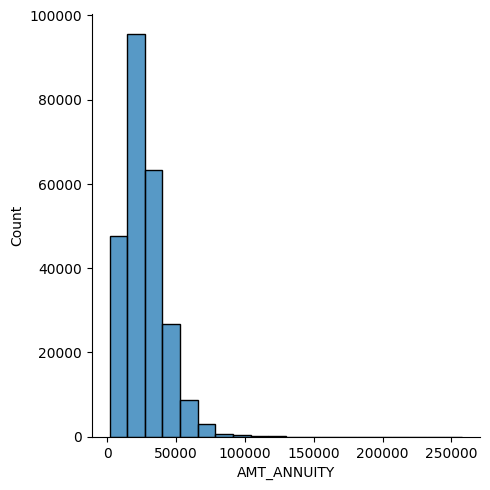

In [ ]:
# Exploring the histogram of the feature
sns.displot(df['AMT_ANNUITY'], bins = 20)
plt.show()

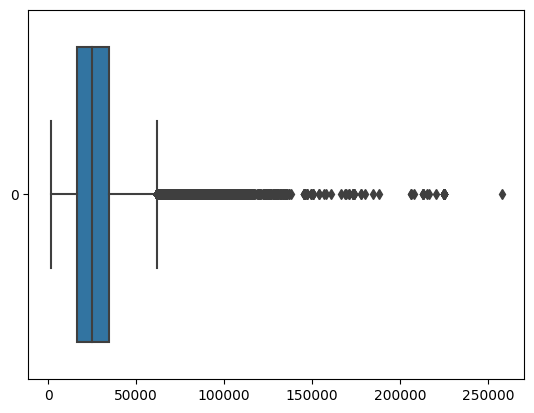

In [ ]:
# Exploring the boxplot of the feature
sns.boxplot(df['AMT_ANNUITY'], orient='h')
plt.show()

<font color='orange'>As we can assess from these plots we have many outliers that we should consider when standardizing the data</font>

#####`DAYS_EMPLOYED`

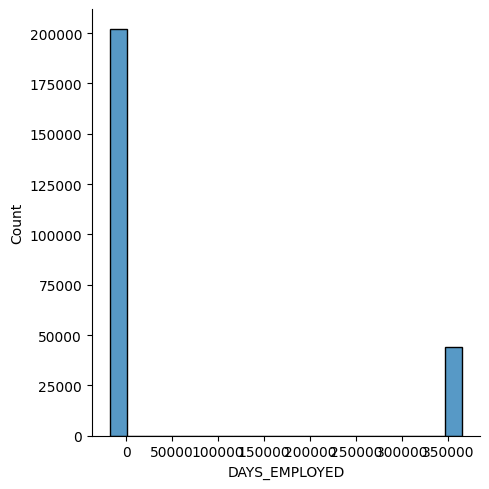

In [ ]:
# Exploring the histogram of the feature
sns.displot(df['DAYS_EMPLOYED'], bins = 20)
plt.show()

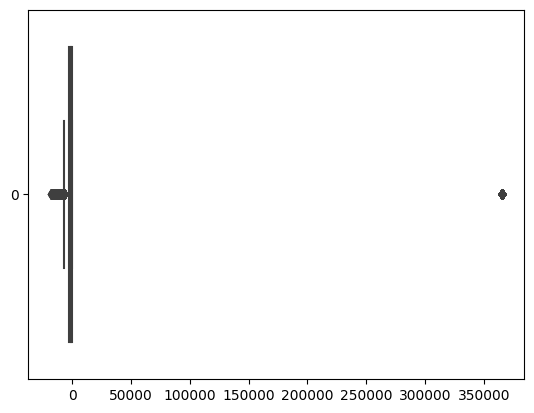

In [ ]:
# Exploring the boxplot of the feature
sns.boxplot(df['DAYS_EMPLOYED'], orient='h')
plt.show()

<font color='orange'>This is a very weird result. We have most observations with values below 0 and many around 350,000.</font>

In [ ]:
# Exploring the extremelly positive values
df.loc[df['DAYS_EMPLOYED'] > 0,'DAYS_EMPLOYED'].unique()[0]

365243

<font color='orange'>The value is 365,243 and should represent all the non-employed clients. This value needs to be corrected since this is an absurd outlier and with a higher frequency in the dataset (it will interfere with the analysis and the modeling).</font>

In [ ]:
# Checking for the income_type of these positive values
df.loc[df['DAYS_EMPLOYED'] > 0,'NAME_INCOME_TYPE'].unique().tolist()

['Pensioner', 'Unemployed']

In [ ]:
# Checking if there are Unemployed that have negative days employed (i.e are working)
df.loc[df['NAME_INCOME_TYPE'] == 'Unemployed', 'DAYS_EMPLOYED'].unique()

array([365243])

In [ ]:
# Checking if there are Pensioner that have negative days employed (i.e are working)
df.loc[df['NAME_INCOME_TYPE'] == 'Pensioner' , 'DAYS_EMPLOYED'].unique()

array([365243,  -1669,  -2341, -12865,  -1346, -11194,  -3261,  -8140,
        -5111])

<font color='orange'>As we can assess these values refer to both groups that are usually not working, even though some pensioners continue to work.</font>


####1.1.5 - Exploring the Target Label

In [ ]:
# Checking the values of the Target Label and count them
df['TARGET'].value_counts()

0    226148
1     19860
Name: TARGET, dtype: int64

In [ ]:
# Checking the percentage of each value
df['TARGET'].value_counts(normalize=True) * 100

0    91.927092
1     8.072908
Name: TARGET, dtype: float64

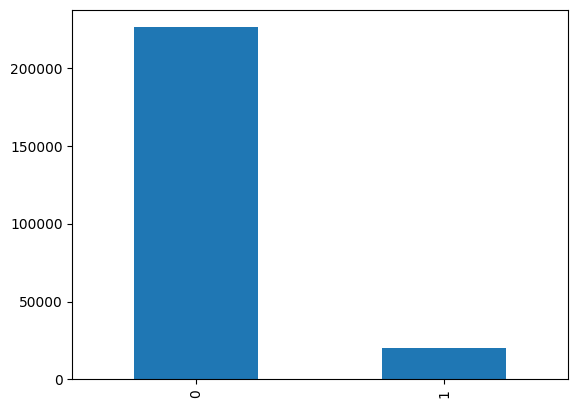

In [ ]:
# Plotting a bar chart of both value counts
df['TARGET'].value_counts().plot(kind='bar')
plt.show()

<font color='orange'>We have an highly imbalanced dataset with only 8% of Defaults. The majority class belongs to the clients that repayed their debts which is not our main focus in this problem.</font>

####1.1.6 - Exploring the Numerical Features

#####Helper Functions

In [ ]:
# Setting a lits with the numerical features
num_feat = [
    'AMT_ANNUITY', 
    'AMT_CREDIT',
    'AMT_GOODS_PRICE', 
    'AMT_INCOME_TOTAL',
    'CNT_CHILDREN',
    'CNT_FAM_MEMBERS',
    'DAYS_BIRTH',
    'DAYS_EMPLOYED',
    'DAYS_ID_PUBLISH',
    'DAYS_LAST_PHONE_CHANGE',
    'DAYS_REGISTRATION',
    'OWN_CAR_AGE'
]

In [ ]:
# Function that returns an overview of a specific numerical variable
def num_var_overview(df, num_cols):
    fig, ax = plt.subplots(4,3, figsize=(15,12))
    axes = ax.ravel()

    for ax, col in zip(axes, num_cols):
        sns.histplot(data=df, x=col, hue='TARGET', bins = 20, ax=ax, legend=False)
        ax.set_title(col, fontsize=9)
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.tick_params(axis='x', labelsize=8)
        ax.tick_params(axis='y', labelsize=8)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    
    plt.show()

In [ ]:
# Function that returns a box plot of the distribution of our specific variable with the target variable
def boxplot_viz(df, num_cols, target_var): 
    fig, ax = plt.subplots(4,3, figsize=(15,12))
    axes = ax.ravel()

    for ax, col in zip(axes, num_cols):
        sns.boxplot(data=df, x=target_var, y=col, ax=ax, showfliers = False)
        ax.set_title(col, fontsize=9)
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.tick_params(axis='x', labelsize=8)
        ax.tick_params(axis='y', labelsize=8)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    plt.show()

##### Overview of the Features

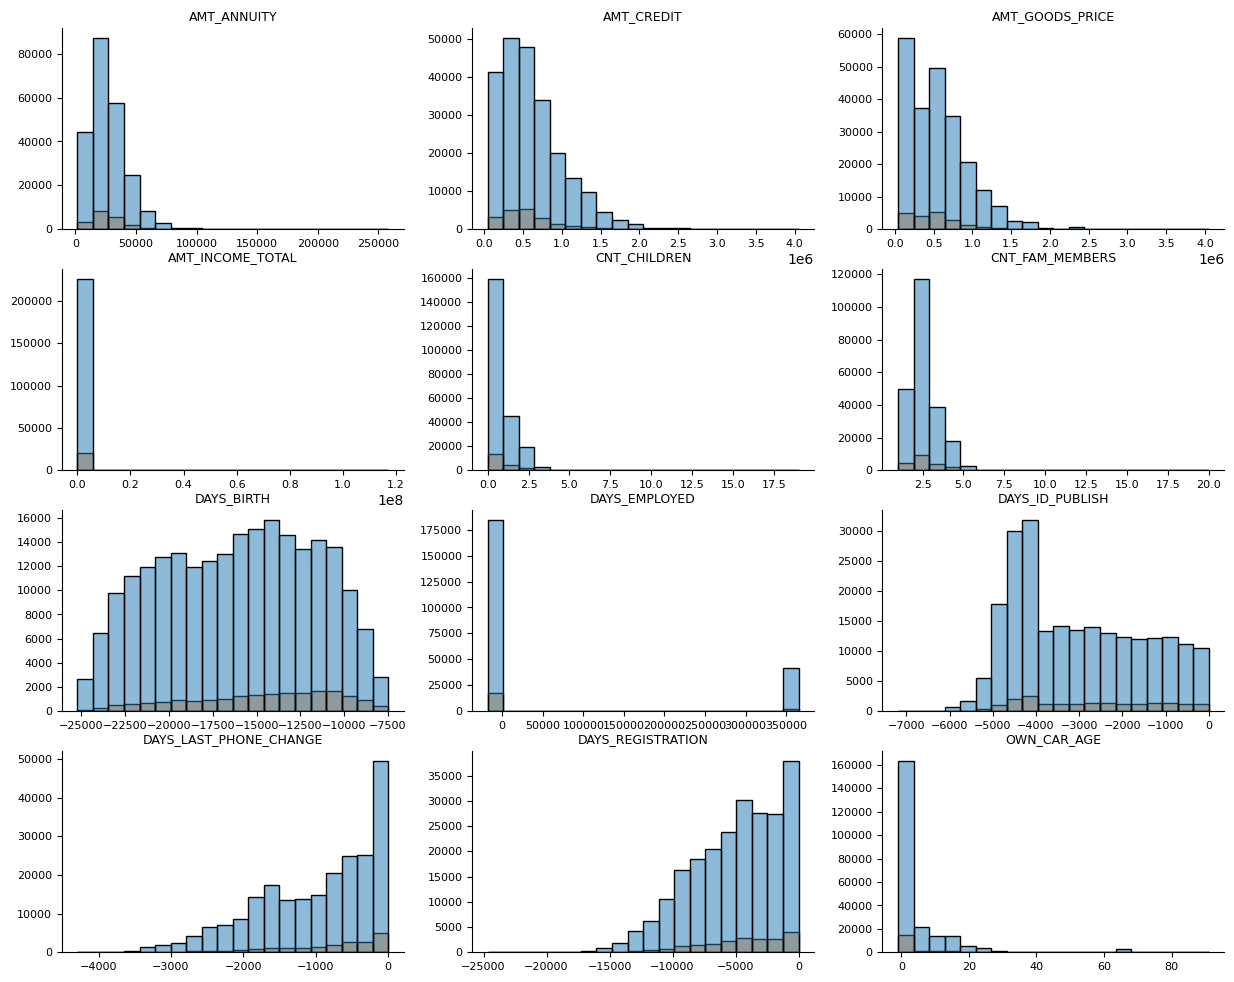

In [ ]:
num_var_overview(df_mod, num_feat)

<font color='orange'>From this overview we can see that most feature distributions are highly skewed with some notable mentions on `AMT_INCOME_TOTAL`, `CNT_CHILDREN`, and `CNT_FAM_MEMBERS`. We have the `DAYS_BIRTH` that could be changed to the age of the person for simplicity. Since most of the feature distributions are skewed we will show boxplots with the outliers removed to serch for patterns in the main data.

The most significant change to be made is on the Feature `DAYS_EMPLOYED` that was already discussed before. </font>

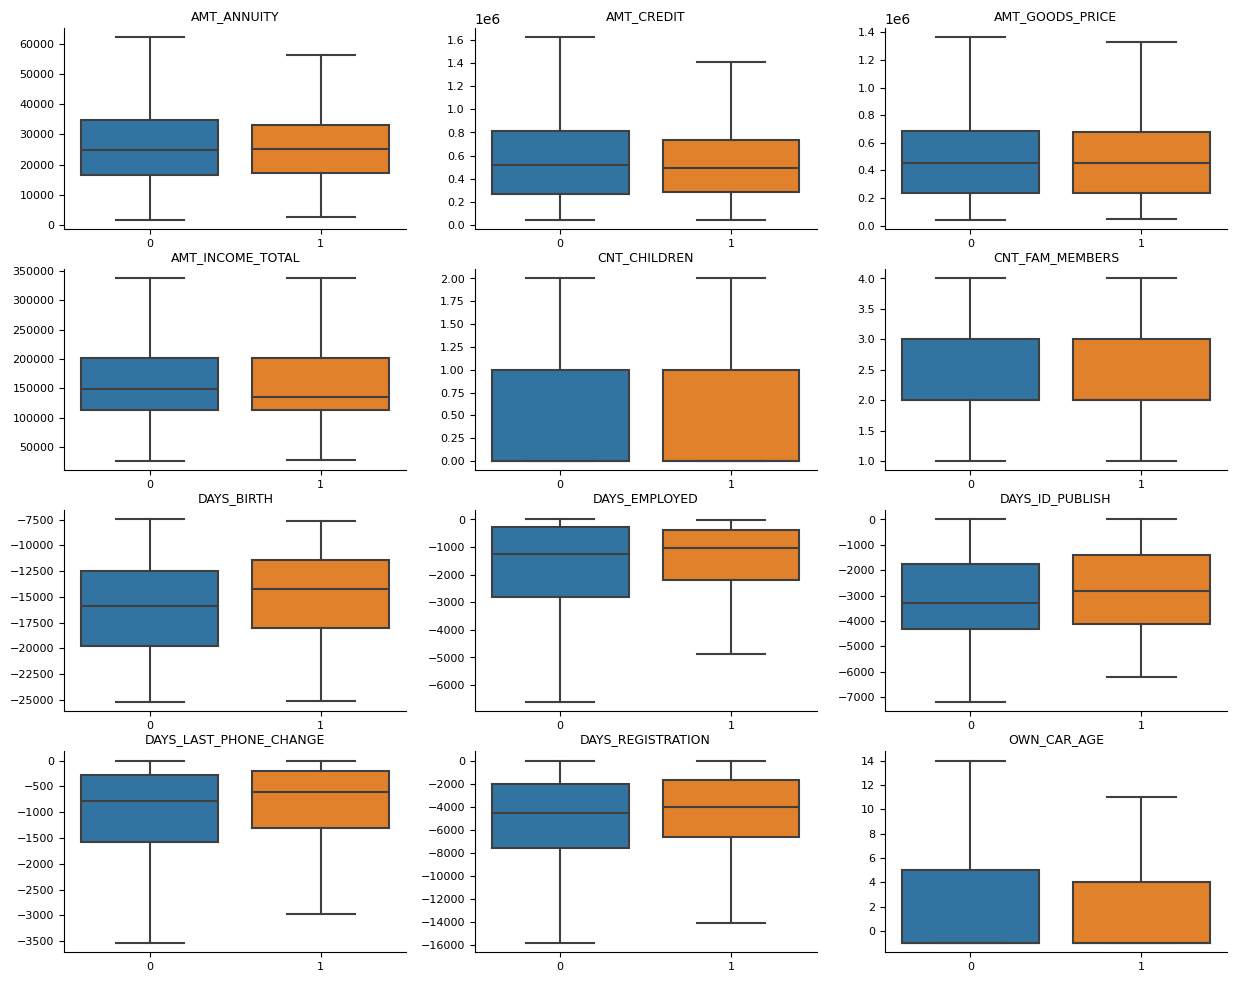

In [ ]:
boxplot_viz(df_mod, num_feat, 'TARGET')

<font color='orange'>Looking at the specific boxplots by `TARGET` label we can only see some differences in `DAYS_BIRTH` and `DAYS_EMPLOYED` features but changing these features is essential at this stage.</font>

######`DAYS_EMPLOYED` -> Changing Weird Values

In [ ]:
# Correcting the positive values to a number closer to 0
df_mod['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].replace(365243, 1)

#####Correlation

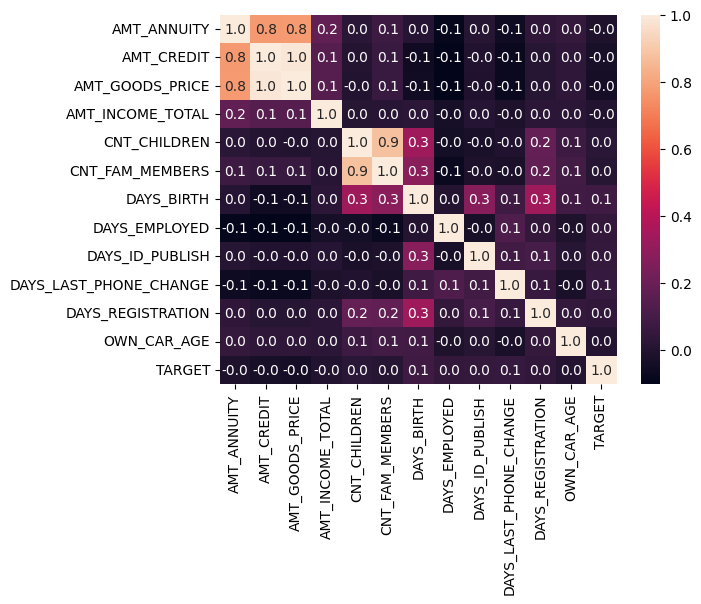

In [ ]:
# Plotting a correlation heatmap including the target.
sns.heatmap(df_mod[num_feat + ['TARGET']].corr(), annot=True, fmt=".1f")
plt.show()

<font color='orange'>Looking at the correlation heatmap we have very low correlation on any feature to the `TARGET` label. One important thing to note is that we have very high collinearity between `CNT_CHILDREN` and `CNT_FAM_MEMBERS`, and also between the 3 features `AMT_ANNUITY`, `AMT_CREDIT`, and `AMT_GOODS_PRICE`. These variables will probably need some fixing to reduce their redundancy, as they are, in fact, very closely related.</font>

####1.1.7 - Exploring the Nominal Features

#####Helper Functions

In [ ]:
cat_feat = [
    'CODE_GENDER', 
    'FLAG_EMAIL',
    'FLAG_MOBIL', 
    'FLAG_OWN_CAR',
    'FLAG_OWN_REALTY',
    'FLAG_PHONE',
    'FLAG_WORK_PHONE',
    'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE',
    'NAME_INCOME_TYPE',
    'OCCUPATION_TYPE'
]

In [ ]:
def cat_var_overview(df, num_cols, target_var):
    fig, ax = plt.subplots(4,3, figsize=(15,12))
    axes = ax.ravel()

    for ax, col in zip(axes, num_cols):
        sns.barplot(data=df, x=col, y=target_var, ax=ax)
        ax.set_title(col, fontsize=9)
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.tick_params(axis='x', labelsize=8)
        ax.tick_params(axis='y', labelsize=8)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    plt.show()

##### Overview of the Features

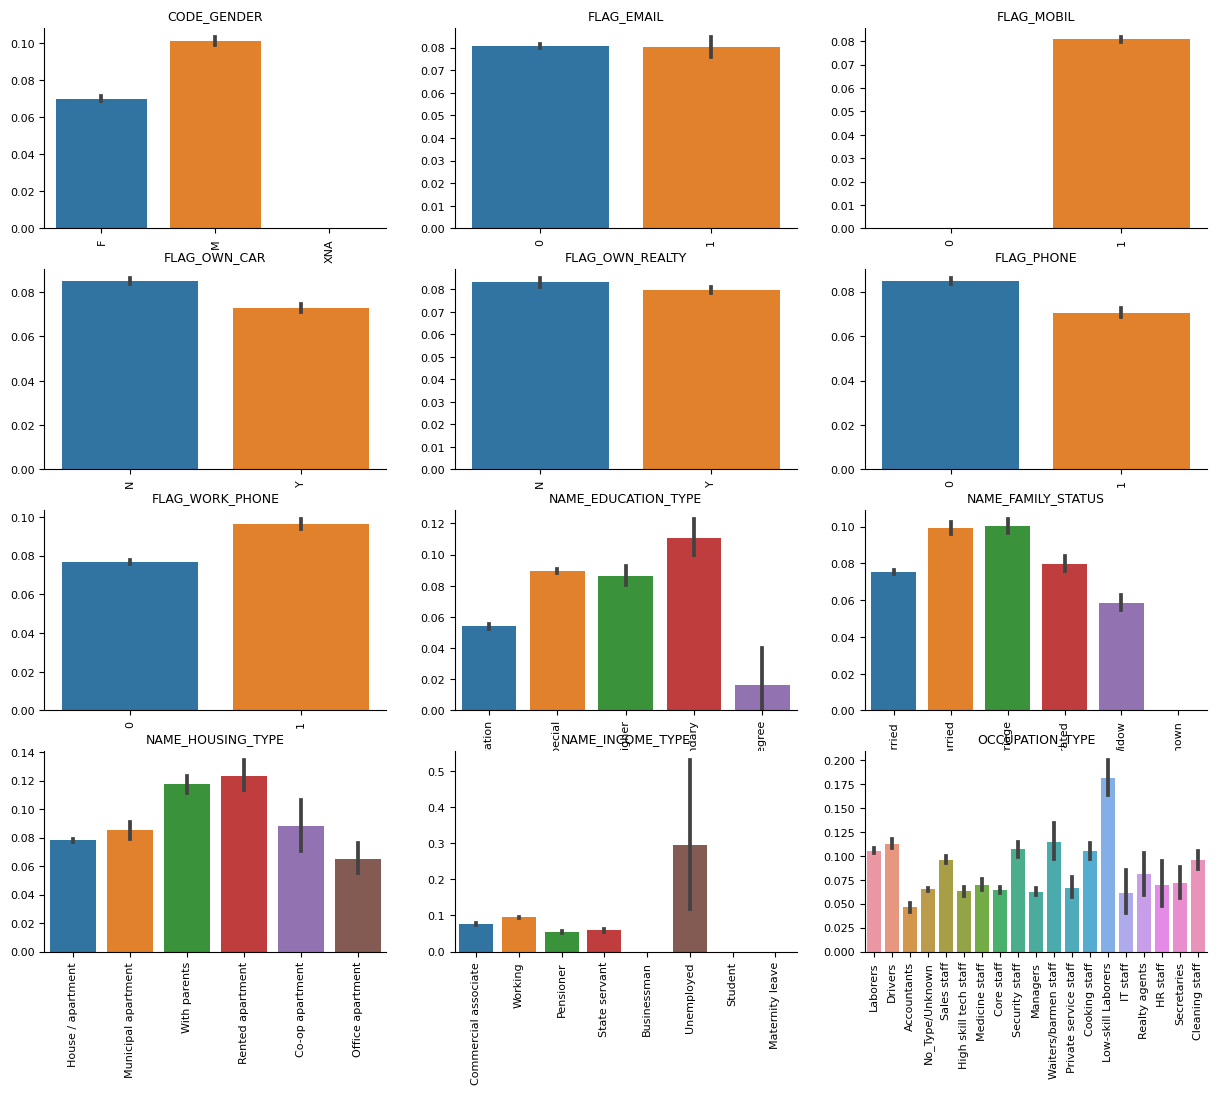

In [ ]:
cat_var_overview(df_mod, cat_feat, 'TARGET')

<font color='orange'>We have some notable groups in the categorical features that might carry good prediction potential, especially `CODE_GENDER`, `FLAG_OWN_CAR`, `FLAG_OWN_REALTY`, `NAME_EDUCATION_TYPE`, `NAME_FAMILY_STATUS`, and `NAME_INCOME_TYPE`.</font>

### 1.2 Preprocess the Dataset

Preprocess the dataset to improve the performance of your machine learning model. This step is crucial as it ensures that the data is clean, well-structured, and optimized for model training. 

Here are some of the points that you should address but you don't need to do all of them:

1. Split the dataset: Divide the dataset into training and testing sets to enable proper model selection in the next task. Remember to use techniques like stratified sampling if the dataset is imbalanced! 
  - You can use the `stratify` parameter of `train_test_split()` to maintain the same class distribution in both train and test sets.
  - For more detailed understanding on the `stratify` parameter, refer to the "What is Stratify in train_test_split?" learning content link

2. Feature engineering: Create new features by combining or transforming existing ones to enhance the model's predictive capabilities. This may include polynomial features, interaction features, or domain-specific transformations.

3. Handle missing values: Determine an appropriate strategy for dealing with missing or null values in the dataset, such as imputing or removing them.
  - Suggestions: 
    - Split the datasets into categorical columns and numerical columns for this step until the end of step 6 like what you did back in J2M5. This will facilitiate using specific `scikit-learn` transformers for each data type. You can always join them together again with `np.hstack()`
    - Use the `SimpleImputer()` `scikit-learn` transformer for filling missing values just like you did back in J2M5. Consider using `strategy='median'` or `strategy='mean'` for the numerical columns. Consider using `strategy='most_frequent'` for replacing missing values with the mode or `strategy='constant'` for categorical columns.
    - The above suggestion will make your solution more robust in case your deployed solution encounters missing values in columns that you did not have in your training and test sets.

4. Handle outliers: Identify and address any outliers in the data, which can distort the model's performance. You may use techniques like the IQR method, Z-score, or clipping to manage outliers.

5. Convert categorical variables: Transform categorical variables into numerical representations using methods such as one-hot encoding or ordinal encoding.
  - Suggestions: 
      - If you want to apply Recursive Feature Elimination (RFE) for feature selection, consider using the `OrdinalEncoder()` `scikit-learn` transformer first, just like you did back in J2M6.
      - After the feature selection process, if the selected features include categorical ones, it's important to decide the most suitable encoding method based on the nature of each categorical variable.
        - For nominal variables with no meaningful order, consider encoding these selected columns using the `OneHotEncoder()` transformer on the original dataset that was used before applying the `OrdinalEncoder()` for Feature Selection. Make sure to set `sparse=False` to avoid getting a sparse matrix and also `handle_unknown='ignore'` to prevent errors if your deployed solution encounters an unseen value in a categorical column.
        - However, if the categorical variable is ordinal (for example, an IMDB ranking of a movie), maintaining its original form might be more appropriate, as this will preserve the inherent order of the categories.

6. Feature scaling: Apply feature scaling techniques, like normalization or standardization, to ensure that all features are on a comparable scale, especially when using models sensitive to feature scales.

7. Evaluation metrics: Choose a relevant evaluation/scoring metric to assess the performance of the models created, such as accuracy, precision, recall, F1-score, and area under the ROC curve (AUC-ROC). Consider the problem's specific requirements and the balance between classes of `TARGET`. **Remember that choosing an adequate "scoring" variable parameter will assist in obtaining a better model.**

8. Feature selection: Use methods like correlation analysis or Recursive Feature Elimination (RFE) to select the most relevant features for your model.

Whenever is possible, set a `random_state` seed in order for your data preprocessing solution is reproducible.

Note: In the final task, you will apply steps 2 to 7 to the entire dataset (without performing a train/test split) as well as using the selected features. This approach will allow you to obtain the deployment model, which should be trained and optimized on the full dataset to ensure the best performance.

In [ ]:
# Adding a random_state seed for you to remember to use it!
RANDOM_STATE=42

In [ ]:
# Step 1 - Splitting the dataset
X = df_mod.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = df_mod['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y)

<font color='orange'>Before going further it is best to perform Feature Selection. We have many features and from EDA it seems that many of them carry very little importance for the problem at hand. For this we will be applying simple transformations, as it is not final.</font>

In [ ]:
# # Numeric Transformations
# numeric_tranformer = Pipeline(steps = [('imputer', SimpleImputer(strategy='median')),
#                                        ('scaler', StandardScaler())])
# # Categorical Transformations
# categorical_tranformer = Pipeline(steps = [('encoder', OrdinalEncoder())])

# # Concatenating the Transformations
# column_transformer = ColumnTransformer(
#     transformers=[
#         ("numeric", numeric_tranformer, num_feat),
#         ("categorical", categorical_tranformer, cat_feat),
#     ])

# # Transforming the Features
# column_transformer.fit(X_train)
# X_train_rfe_proc = pd.DataFrame(column_transformer.transform(X_train), columns=num_feat + cat_feat)

# # Performing RFECV
# rfc = RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=RANDOM_STATE)
# feat_sel = RFECV(estimator=rfc, cv=5, scoring='roc_auc')
# feat_sel.fit(X_train_rfe_proc, y_train)

In [ ]:
# for col in X.columns:
#     if col not in feat_sel.get_feature_names_out().tolist():
#         print(col)

<font color='orange'>`FLAG_MOBIL` came out as a useless feature to use in the model. Now, we can restart the preprocessing with the proper Scalers and Encoders for our models.</font>

In [ ]:
# Removing the unwanted feature
cat_feat.remove('FLAG_MOBIL')

In [ ]:
# Numeric Transformations
numeric_tranformer = Pipeline(steps = [('imputer', KNNImputer()),
                                       ('scaler', RobustScaler())])
# Categorical Transformations
categorical_tranformer = Pipeline(steps = [('encoder', OneHotEncoder(sparse_output=False))])

# Concatenating the Transformations
column_transformer = ColumnTransformer(
    transformers=[
        ("numeric", numeric_tranformer, num_feat),
        ("categorical", categorical_tranformer, cat_feat),
    ])

# Transforming the Features
column_transformer.fit(X_train)
feature_names = np.hstack((column_transformer.transformers_[0][1][0].feature_names_in_,
                          column_transformer.transformers_[1][1].get_feature_names_out()))
X_train_processed = pd.DataFrame(column_transformer.transform(X_train), columns=feature_names)
X_test_processed = pd.DataFrame(column_transformer.transform(X_test), columns=feature_names)

### 1.3 Selecting your Model

You will now choose an appropriate classification model for this problem and perform an initial comparison to identify the most promising candidate. You should do the following:

1.  Identify candidate models: Consider models that you have applied in the past such as logistic regression, decision tree, random forest, and lightgbm.

2. Evaluation metrics: Choose a relevant evaluation metric to assess the performance of each model, such as accuracy, precision, recall, F1-score, and area under the ROC curve (AUC-ROC). Consider the problem's specific requirements and the balance between classes of `TARGET`.

3. Cross-validation: Perform cross-validation with the chosen metric to obtain reliable performance estimates for each model.

4. Model selection: Based on the results of the cross-validation, select the most promising model for further optimization and tuning.

<font color='orange'>We know about 4 models for Classification that can be a fit here:
- DecisionTreeClassifier
- RandomForestClassifier
- LightGBM
- Logistic Regression

The KNN Classifier is not good for this problem as we end up with too many features.
</font>

In [ ]:
# # Instantiating and getting the best score for each of the base models.
# models = {
#     'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
#     'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
#     'LightGBM': LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1),
#     'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1),
# }

# score_results = {}
# best_result = 0
# for model_name, model in models.items():
#     scores = cross_val_score(model, X_train_processed, y_train,
#                             cv=StratifiedKFold(shuffle=True, random_state=RANDOM_STATE), scoring='roc_auc')
#     mean_score = scores.mean()
#     score_results[model_name] = mean_score
#     best_result = mean_score if mean_score > best_result else best_result

# for model_name, results in score_results.items():
#     print(f"{model_name}: {results:.4f} {'<---' if results == best_result else ''}")

<font color='orange'>We got very promising results from LightGBM and Logistic Regression, even though the other 2 models had decent results. Starting the testing from the worst performing model to the best one.</font>

### 1.4 Tuning your Model

You will now fine-tune the hyperparameters of the selected classification model to optimize its performance. Ideally, you should tune and compare the performance of all potential models to identify the best performing one post-tuning. However, if this is the first time you are doing this task, simply focus on the model that initially performed the best for now. In a real-world scenario, it would be beneficial to tune various different ML models before making a final choice. Now, let's proceed with the following steps:

1. **Identify hyperparameters:** List the hyperparameters of the selected model that can be tuned to optimize performance. Check the ones that were used back in J2M5, but here you have a comprehensive list of hyperparameters that you can tune as well as one example of options:
    - **Logistic Regression:**
        - `'C': [0.1, 1, 10]`
        - `'class_weight': [None, 'balanced']`
        
    - **Decision Tree:**
        - `'max_depth': [None, 5, 10, 20]`
        - `'min_samples_split': [2, 5, 10]`
        - `'min_samples_leaf': [1, 5, 10]`
        - `'class_weight': [None, 'balanced']`
        
    - **Random Forest:**
        - `'n_estimators': [50, 100, 200]`
        - `'max_depth': [None, 5, 10, 20]`
        - `'min_samples_split': [2, 5, 10]`
        - `'min_samples_leaf':  [1, 5, 10]`
        - `'max_features':  ['auto', 'sqrt', 'log2']`
        - `'class_weight': [None, 'balanced']`
        
    - **LightGBM:**
        - `'n_estimators': [100, 200, 500]`
        - `'learning_rate': [0.01, 0.05, 0.1]`
        - `'max_depth': [5, 10, -1]`
        - `'num_leaves': [31, 50]`
        - `'min_child_samples':  [20, 50]`
        - `'subsample': [0.8, 1]`
        - `'colsample_bytree': [0.8, 1]`
        - `'class_weight': [None, 'balanced']`

2. **Define the search space:** Specify the range of possible values for each hyperparameter to be tuned. Ensure that the search space is reasonably wide to explore various combinations while keeping computational constraints in mind. Take into consideration that the more complex the grid is, the longer the tuning will take.

3. **Cross-validation during tuning:** Apply cross-validation with `GridSearchCV()` to obtain more reliable performance estimates and prevent overfitting. The larger the `cv` argument is, the more reliable the performance estimates but at the cost of longer hyperparameter tuning durations.

4. **Obtain the best combination of hyperparameters:** These will be used in the next task to train the optimized model. 

5. **(OPTIONAL) Compare several tuned ML models:** Consider tuning other ML models as well when you have more time, and compare them to ensure you're getting the best possible performance.

**Tip**: If the hyperparameter tuning is taking too long, consider either reducing the search space and/or using a smaller sample of the training dataset by doing.:
```
# Calculate 10% of the total elements in the array
num_elements = X_train_preprocessed.shape[0]
subset_size = int(0.1 * num_elements)

# Generate random indices
random_indices = np.random.choice(num_elements, size=subset_size, replace=False)

# Create a new array with the random indices
X_subset = X_train_preprocessed[random_indices]
y_subset = y_train[random_indices]
```

In [ ]:
# Calculate 10% of the total elements in the array
num_elements = X_train_processed.shape[0]
subset_size = int(0.1 * num_elements)

# Generate random indices
random_indices = np.random.choice(num_elements, size=subset_size, replace=False)

# Create a new array with the random indices
X_subset = X_train_processed.iloc[random_indices]
y_subset = y_train.iloc[random_indices]

<font color='orange'>Reducing the search space for easier tuning. 

Below there is a dataframe to store the results of the model tuning.</font>

In [ ]:
# Preparing a Dataset to store the best results and models
tuning_df = pd.DataFrame(columns=['MODEL', 'ROC_AUC_SCORE'])

# Adding the DT results
tuning_df.loc[0, 'MODEL'] = DecisionTreeClassifier(min_samples_leaf=520, random_state=RANDOM_STATE)
tuning_df.loc[0, 'ROC_AUC_SCORE'] = 0.6272921181467906

# Adding the RF results
tuning_df.loc[1, 'MODEL'] = RandomForestClassifier(max_depth=8, max_features='log2', min_samples_leaf=10, min_samples_split=5, n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1)
tuning_df.loc[1, 'ROC_AUC_SCORE'] = 0.6782318776435913

# Adding the LogR results
tuning_df.loc[2, 'MODEL'] = LogisticRegression(C=0.6, penalty='l1', solver='liblinear', random_state=RANDOM_STATE, n_jobs=1)
tuning_df.loc[2, 'ROC_AUC_SCORE'] = 0.6664545207439369

# Adding the LGBM results
tuning_df.loc[3, 'MODEL'] = LGBMClassifier(class_weight=None, colsample_bytree=0.7, learning_rate=0.02, max_depth=3, min_child_samples=1100, n_estimators=350, num_leaves=20, subsample=0.95, random_state=RANDOM_STATE, n_jobs=-1)
tuning_df.loc[3, 'ROC_AUC_SCORE'] = 0.6624240699081301

tuning_df

,MODEL,ROC_AUC_SCORE
0,"DecisionTreeClassifier(min_samples_leaf=520, r...",0.627292
1,"RandomForestClassifier(max_depth=8, max_featur...",0.678232
2,"LogisticRegression(C=0.6, n_jobs=1, penalty='l...",0.666455
3,"LGBMClassifier(colsample_bytree=0.7, learning_...",0.662424


####DECISION TREE

In [ ]:
# # Define the search space
# param_grid = {
#     'max_depth': [None, 5, 7, 10, 15, 20],
#     'min_samples_split': [2, 5, 10, 20, 30],
#     'min_samples_leaf': [480, 500, 520, 550, 575, 600, 650],
#     'class_weight': [None, 'balanced']
# }

# # Instantiate your chosen model
# model = DecisionTreeClassifier(random_state=RANDOM_STATE)

# # Instantiate GridSearchCV to perform stratified cross-validation
# cv = StratifiedKFold(n_splits=3, random_state=RANDOM_STATE, shuffle=True)
# grid_search = GridSearchCV(
#     model,
#     param_grid,
#     cv=cv,
#     scoring='roc_auc',
#     verbose=1,
# )

# # Fit your grid_search using your preprocessed dataset
# # Consider sampling your training dataset
# grid_search.fit(X_subset, y_subset)

# # Obtain the best combination of hyperparameters:
# best_params = grid_search.best_params_
# print("Best hyperparameters:")
# print(best_params)
# print(f"Best Score: {grid_search.best_score_}")

In [ ]:
# dt_results = pd.DataFrame()
# dt_results['PARAMS'] = grid_search.cv_results_['params']
# dt_results['ROC_AUC_SCORE'] = grid_search.cv_results_['mean_test_score']
# dt_results.sort_values('ROC_AUC_SCORE', ascending=False)

<font color='orange'>1 - Max_depth 5 was a clear winner in first iteration and criterion didn't seem to play a big role as well as min_samples_split.\
2 - High min_samples_leaf (200) seems to improve performance along with max_depth of around 5 -> 15.\
3 - Still benefiting from min_sample_leaf counts and aparentelly min_samples_split.\
4 - Still improving with min_sample_leaf but now with very slight improvement.\
5 - A 500 to 600 value on min_sample_leaf seems to halt the improvement on this road.\
BEST_SCORE = 0.6272921181467906</font>

####RANDOM FOREST

In [ ]:
# # Define the search space
# param_grid = {
#     'n_estimators': [250, 300, 350],
#     'max_depth': [8, 9],
#     'min_samples_split': [5, 10, 15],
#     'min_samples_leaf':  [5, 10, 15],
#     'max_features':  ['sqrt', 'log2'],
#     'class_weight': [None, 'balanced']
# }

# # Instantiate your chosen model
# model = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

# # Instantiate GridSearchCV to perform stratified cross-validation
# cv = StratifiedKFold(n_splits=3, random_state=RANDOM_STATE, shuffle=True)
# grid_search = GridSearchCV(
#     model,
#     param_grid,
#     cv=cv,
#     scoring='roc_auc',
#     verbose=1,
# )

# # Fit your grid_search using your preprocessed dataset
# # Consider sampling your training dataset
# grid_search.fit(X_subset, y_subset)

# # Obtain the best combination of hyperparameters:
# best_params = grid_search.best_params_
# print("Best hyperparameters:")
# print(best_params)
# print(f"Best Score: {grid_search.best_score_}")

In [ ]:
# rf_results = pd.DataFrame()
# rf_results['PARAMS'] = grid_search.cv_results_['params']
# rf_results['ROC_AUC_SCORE'] = grid_search.cv_results_['mean_test_score']
# rf_results.sort_values('ROC_AUC_SCORE', ascending=False)

<font color='orange'>1 - The first run shows one value that should be interesting to pursue n_estimators (increasing might show better values).\
2 - Some slight increase with higher number of n_estimators.\
3 - 200 to 350 n_estimators seem to draw the best results. Using other params next within this range.\
4 - Max_depth of 7 is a clear winner. \
5 - Max_depth of 8 is better... let's check 9 and a few other...\
BEST_SCORE = 0.6782318776435913</font>

####LOGISTIC REGRESSION

In [ ]:
# # Define the search space
# param_grid = {
#     'penalty': ['l1'],
#     'solver': ['liblinear'],
#     'C': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
#     'class_weight': [None, 'balanced']
# }

# # Instantiate your chosen model
# model = LogisticRegression(random_state=RANDOM_STATE)

# # Instantiate GridSearchCV to perform stratified cross-validation
# cv = StratifiedKFold(n_splits=3, random_state=RANDOM_STATE, shuffle=True)
# grid_search = GridSearchCV(
#     model,
#     param_grid,
#     cv=cv,
#     scoring='roc_auc',
#     verbose=1,
# )

# # Fit your grid_search using your preprocessed dataset
# # Consider sampling your training dataset
# grid_search.fit(X_subset, y_subset)

# # Obtain the best combination of hyperparameters:
# best_params = grid_search.best_params_
# print("Best hyperparameters:")
# print(best_params)
# print(f"Best Score: {grid_search.best_score_}")

In [ ]:
# logr_results = pd.DataFrame()
# logr_results['PARAMS'] = grid_search.cv_results_['params']
# logr_results['ROC_AUC_SCORE'] = grid_search.cv_results_['mean_test_score']
# logr_results.sort_values('ROC_AUC_SCORE', ascending=False)

<font color='orange'>1 - Any C is performing well with L2. Good C between 0.1 and 0.5 \
2 - C 0.3 -> 0.5 gives good score on L2. \
3 - l1 performs better with 0.4 -> 0.6\
BEST_SCORE = 0.6664545207439369</font>

####LGBM

In [ ]:
# # Define the search space
# param_grid = {
#     'n_estimators': [350, 400, 450],
#     'learning_rate': [0.01, 0.02, 0.03],
#     'max_depth': [3],
#     'min_child_samples': [1100, 1300],
#     'num_leaves': [20, 300, 1500],
#     'subsample': [0.95],
#     'colsample_bytree': [0.7, 0.8],
#     'class_weight': [None]
# }

# # Instantiate your chosen model
# model = LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1)

# # Instantiate GridSearchCV to perform stratified cross-validation
# cv = StratifiedKFold(n_splits=3, random_state=RANDOM_STATE, shuffle=True)
# grid_search = GridSearchCV(
#     model,
#     param_grid,
#     cv=cv,
#     scoring='roc_auc',
#     verbose=1,
# )

# # Fit your grid_search using your preprocessed dataset
# # Consider sampling your training dataset
# grid_search.fit(X_subset, y_subset)

# # Obtain the best combination of hyperparameters:
# best_params = grid_search.best_params_
# print("Best hyperparameters:")
# print(best_params)
# print(f"Best Score: {grid_search.best_score_}")

In [ ]:
# lgbm_results = pd.DataFrame()
# lgbm_results['PARAMS'] = grid_search.cv_results_['params']
# lgbm_results['ROC_AUC_SCORE'] = grid_search.cv_results_['mean_test_score']
# lgbm_results.sort_values('ROC_AUC_SCORE', ascending=False)

<font color='orange'>1 - Max-depth of 5, learning rate of 0.01 and estimators > 200 seem the winners.\
2 - Max-depth of 3 is better, learning 0.01 -> 0.03.\
3 - Subsample is too variante, bytree of 0.7 and 0.8 is giving good results.\
BEST_SCORE = 0.6624240699081301</font>

### 1.5 Training and Evaluating your Optimized Model

You will now train your optimized model and evaluating its performance. You should to the following:

1. **Train the tuned model:** Train your model using the optimized hyperparameters with the training dataset.

2. **Evaluate the tuned model:** Obtain the test set predictions and use your chosen metric to evaluate the model predictions.

3. **Compare the test metric with the one you obtained in 1.3 or 1.4:** If the metrics are relatively close, then there aren't any signs of overfitting and we're good to go!

In [ ]:
# Training the models and getting the probabilities for each
model_names = ['DT', 'RF', 'LogR', 'LGBM']
probas_results = {}

for model_name, model in zip(model_names, tuning_df['MODEL']):
    model.fit(X_train_processed, y_train)

    # Getting the model probabilities 
    y_probas = model.predict_proba(X_test_processed)[:, 1]
    probas_results[model_name] = y_probas

In [ ]:
# Getting the scores
for model_name in model_names:
    score = roc_auc_score(y_test, probas_results[model_name])
    print(f'{model_name}: {score:.4f}')

DT: 0.6360
RF: 0.6580
LogR: 0.6636
LGBM: 0.6727


<font color='orange'>None of the tested model show signs of overfitting. Overall, all of them are showing similar performance between the training and the test sets.</font>

### 1.6 Optimize your probability threshold for the final model predictions

You will now optimize the probability threshold for your final model's predictions based on the cost matrix shared by the bank! This step is crucial for achieving the best performance in terms of minimizing the overall cost of classification errors, taking into account the problem's specific requirements and consequences of different types of errors. 

A cost matrix is a table that quantifies the cost associated with each type of classification error, such as false positives and false negatives. By adjusting the probability threshold, you can control the trade-off between the various error types, making the classification more cost-sensitive and tailored to the specific problem. For instance, False Negatives have a much higher cost than False Positives according to the bank! 

To calculate the expected cost using the cost matrix, you can use the following formula:

$$
Expected\,Cost = C_{11} \times TN + C_{22} \times TP + C_{12} \times FN + C_{21} \times FP
$$

Where:

- $C_{11}$ is the cost of true negatives
- $C_{22}$ is the cost of true positives
- $C_{12}$ is the cost of false negatives
- $C_{21}$ is the cost of false positives
- $TP$ is the number of true positives
- $TN$ is the number of true negatives
- $FP$ is the number of false positives
- $FN$ is the number of false negatives

By minimizing the expected cost, you can find the optimal probability threshold for your classification model, taking into account the specific costs associated with each type of classification error.

Your tasks are as follows:

1. **Understand the cost matrix:** Analyze the given cost matrix and understand the implications of each type of classification error.

2. **Complete the `optimized_threshold()` function to obtain the optimal threshold:** For each possible probability threshold, calculate the expected cost of classification errors based on the cost matrix and the model's confusion matrix at that threshold. In the end, identify the probability threshold that minimizes the expected cost. This threshold will be used to convert the model's predicted probabilities into binary class labels (e.g., repay (0) or default (1)).

3. **Run the completed `optimized_threshold()` function to obtain the optimal threshold**

By completing this subtask, you will have tailored your model's predictions to the specific problem by minimizing the overall cost of classification errors using the cost matrix. You will be ready to estimate how much profit your model could have given to the bank. This will be done on the next task 1.7.

In [ ]:
# Complete the optimized_threshold() function
def optimized_threshold(y_true, y_probs, amt_credit):
    """
    Finds the optimized threshold based on the expected cost using the credit amounts.

    Parameters:
    y_true (np.ndarray): True labels of the instances.
    y_probs (np.ndarray): Predicted probabilities for the positive class.
    amt_credit (pd.Series): Credit amount for each instance.

    Returns:
    float: The optimal probability threshold that minimizes the expected cost.
    """
    thresholds = np.linspace(0, 1, 101)
    costs = []
    for threshold in thresholds:
        y_pred = (y_probs >= threshold).astype(int)
        
        # Obtain the FP_indices and FN_indices
        FP_indices = np.where((y_true == 0) & (y_pred == 1))
        FN_indices = np.where((y_true == 1) & (y_pred == 0))

        # Calculate the cost for false positives and for false negatives
        FP_cost = np.sum(-0.25 * amt_credit.iloc[FP_indices])
        FN_cost = np.sum(-1 * amt_credit.iloc[FN_indices])

        # Calculate the overall cost
        cost = FP_cost + FN_cost
        costs.append(cost)

    # Find the threshold that minimizes the total costs
    optimal_threshold = thresholds[np.argmax(costs)] # Tip: use np.argmax() to get the index of costs that is closest to zero (minimizing costs) and use it on the thresholds array
    
    return optimal_threshold

In [ ]:
# Getting the models threshold
print('-- Thresholds --')
p_thresholds = {}
for model_name in model_names:
    threshold = optimized_threshold(y_test, probas_results[model_name], X_test['AMT_CREDIT'])
    p_thresholds[model_name] = threshold
    print(f'{model_name}: {threshold}')

-- Thresholds --
DT: 0.23
RF: 0.15
LogR: 0.19
LGBM: 0.17


### 1.7 Estimate the expected profit

You will now obtain the final model's predictions using the optimal probability threshold, and calculate the total profit in $ using the `expected_profit()` function that applies following formula:

$$
Expected\,Profit = \sum_{i \in TN} (0.25 \times AMT\_CREDIT_i) - \sum_{j \in FN} AMT\_CREDIT_j
$$

The bank has a profit with the paid interest from each repayed loan and has a loss when their customer defaults. Here, the sums are taken over all instances $i$ classified as true negatives (TNs) and all instances $j$ classified as false negatives (FNs). `AMT_CREDIT_i` and `AMT_CREDIT_j` represent the credit amount for each instance in the respective sets.

You should do the following:
1. Round your test set predictions using the optimized threshold.
2. Calculate the total profit in $ with the `expected_profit()` function using:
  * The test set model predictions
  * Naïve predictions of accepting all loans (classifying everything as Repay (0))
3. Obtain how much average profit per application the model can bring over the naïve approach

By completing this subtask, you will obtain an estimate how much profit your model could have given to the bank.

In [ ]:
# You can leave this function as it is
def expected_profit(y_true, y_pred, amt_credit):
    """
    Calculate the expected profit using the formula.

    Parameters:
    y_true (np.ndarray): True labels of the instances.
    y_pred (np.ndarray): Predicted labels of the instances.
    amt_credit (pd.Series): Credit amount for each instance.

    Returns:
    float: The expected profit.
    """
    TN_indices = np.where((y_true == 0) & (y_pred == 0))
    FN_indices = np.where((y_true == 1) & (y_pred == 0))
    
    TN_profit = np.sum(0.25 * amt_credit.iloc[TN_indices])
    FN_cost = np.sum(amt_credit.iloc[FN_indices])
    
    profit = TN_profit - FN_cost
    
    return profit

In [ ]:
# Calculate the improve in profits compared to a naive model.
naive_preds = np.zeros(len(y_test))

for model_name in model_names:
    y_preds = np.zeros(len(y_test))
    y_preds[probas_results[model_name] >= p_thresholds[model_name]] = 1

    model_profits = expected_profit(y_test, y_preds, X_test['AMT_CREDIT'])
    naive_profits = expected_profit(y_test, naive_preds, X_test['AMT_CREDIT'])

    print(f"{model_name} Model: {((model_profits - naive_profits) / len(y_test)):.2f}$ per client.")

DT Model: 296.30$ per client.
RF Model: 87.69$ per client.
LogR Model: 677.80$ per client.
LGBM Model: 574.94$ per client.


### 1.8 Train your final model for deployment

It's finally time to obtain your final data preprocessing and model pipeline for deployment.

You will now use the the full, original dataset (before the train/test split) to do the following:
1. Engineer new features (only if you engineered new features previously).
2. Re-train your data preprocessing components (e.g., scalers, encoders, etc.).
3. Transform your dataset using the data preprocessing components.
4. Select the final features that you want to keep (use the selected features that your obtained previously).
3. Re-train your final model. 

By leveraging the optimized hyperparameters and the entire dataset, you can maximize the performance of your model. This final model will be better suited for real-world deployment, as it takes advantage of all available data to generalize and perform well on new, unseen data. 

After training, you'll have a robust model that is ready for deployment and can be used to predict loan repayment capabilities in a practical setting.

In [ ]:
# Setting the final features to be used
final_num_features = ['AMT_ANNUITY','AMT_CREDIT','AMT_GOODS_PRICE','AMT_INCOME_TOTAL','CNT_CHILDREN','CNT_FAM_MEMBERS',
                      'DAYS_BIRTH','DAYS_EMPLOYED','DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE','DAYS_REGISTRATION','OWN_CAR_AGE']

final_cat_features = ['CODE_GENDER', 'FLAG_EMAIL', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_PHONE', 'FLAG_WORK_PHONE',
                      'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE']

# Numeric Transformations
numeric_tranformer = Pipeline(steps = [('imputer', KNNImputer()),
                                       ('scaler', RobustScaler())])
# Categorical Transformations
categorical_tranformer = Pipeline(steps = [('encoder', OneHotEncoder(sparse_output=False))])

# Concatenating the Transformations
column_transformer = ColumnTransformer(
    transformers=[
        ("numeric", numeric_tranformer, final_num_features),
        ("categorical", categorical_tranformer, final_cat_features),
    ])

# Using the preprocessed features with our final model
pipeline = Pipeline(steps = [('preprocessed', column_transformer),
                             ('classifier', LogisticRegression(C=0.6, penalty='l1', solver='liblinear', random_state=RANDOM_STATE, n_jobs=1))])

pipeline.fit(X, y)

Pipeline(steps=[('preprocessed',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['AMT_ANNUITY', 'AMT_CREDIT',
                                                   'AMT_GOODS_PRICE',
                                                   'AMT_INCOME_TOTAL',
                                                   'CNT_CHILDREN',
                                                   'CNT_FAM_MEMBERS',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_ID_PUBLISH',
                                                   'DAYS_LAST_PHONE_CHANGE',
                                                   'DAYS_REGISTRATION',
                                                   'OWN_CAR_AGE']),...
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['CODE_GENDER', 'FLAG_EMAIL',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'FLAG_PHONE',
                                                   'FLAG_WORK_PHONE',
                                                   'NAME_EDUCATION_TYPE',
                                                   'NAME_FAMILY_STATUS',
                                                   'NAME_HOUSING_TYPE',
                                                   'NAME_INCOME_TYPE',
                                                   'OCCUPATION_TYPE'])])),
                ('classifier',
                 LogisticRegression(C=0.6, n_jobs=1, penalty='l1',
                                    random_state=42, solver='liblinear'))])

### 1.9 Export your final model and other Scikit-Learn transformers

In this subtask, you'll learn how to export your final model and associated preprocessing components, such as feature scaling, encoding, and any other transformers used during the data preparation process. By saving these components, you'll ensure a seamless deployment of your machine learning pipeline.

Exporting your trained model and preprocessing components is essential for maintaining consistency when making predictions on new data. This step enables you to load and use the same preprocessing steps and model in your deployed service, ensuring reliable performance.

Do the following steps:
1. Go through the second learning content link.
2. Import the `joblib` library.
3. Save the final model: In order to save your final model, utilize the `joblib.dump()` function. Provide the model object as the value argument and specify the file path where you want the model to be saved as the filename argument. Add a `.pkl` extension to your model filename (e.g. `model.pkl`) as it will be a Pickle binary file.
4. Save data preprocessing components: Similarly, save any preprocessing components (e.g., scalers, encoders, etc.) using the `joblib.dump()` function. Also add a `.pkl` extension to your data preprocessing component filename (e.g. `encoder.pkl`) as it will be a Pickle binary file.
5. Load the saved model and components with new variable names: Once you have saved your model and preprocessing components, you can load them back into your script or notebook using the `joblib.load()` function.
6. (Optional) In case you want to work on Activity 2 in a later time, you could also save and load your saved model and preprocessing components on Google Drive. Check how to do it in the "*How to save our model to Google Drive and reuse it*" learning content link. Alternatively, you can simply download your `.pkl` files and upload them again later on.

Now that you have exported your final model and preprocessing components, you can use the loaded versions to preprocess new data and make predictions in the same manner as you did with the original objects. These exported files are essential for the upcoming tasks, where you'll deploy your machine learning pipeline in a real-world setting. By ensuring consistency between the development and deployment phases, you can maintain the reliability and performance of your predictions.

In [ ]:
# Exporting our model
joblib.dump(value=pipeline, filename='model_pipeline.pkl')

['model_pipeline.pkl']

## 2. Deploying your Machine Learning Pipeline with Flask on Google Colab

It now starts to be exciting! In this activity, you will finally learn how to create a Flask application to expose your machine learning pipeline as a REST API. This will allow the bank to send data to your application and receive predictions on whether a loan will default or not.

The bank has agreed that it will send single loan application requests to your application with the following JSON format:

```
request = {
  "id": 123456,
  "data": {
      "AMT_ANNUITY": 24700.5,
      "AMT_CREDIT": 406597.5,
      "AMT_GOODS_PRICE": 351000,
      "AMT_INCOME_TOTAL": 202500,
      "CNT_CHILDREN": 0,
      "CNT_FAM_MEMBERS": 1,
      "DAYS_BIRTH": -9461,
      "DAYS_EMPLOYED": -637,
      "DAYS_ID_PUBLISH": -2120,
      "DAYS_LAST_PHONE_CHANGE": -1134,
      "DAYS_REGISTRATION": -3648.0,
      "OWN_CAR_AGE": null,
      "CODE_GENDER": "M",
      "FLAG_EMAIL": 0,
      "FLAG_OWN_CAR": "N",
      "FLAG_OWN_REALTY": "Y",
      "FLAG_PHONE": 1,
      "FLAG_WORK_PHONE": 0,
      "NAME_EDUCATION_TYPE": "Secondary / secondary special",
      "NAME_FAMILY_STATUS": "Single / not married",
      "NAME_HOUSING_TYPE": "House / apartment",
      "NAME_INCOME_TYPE": "Working",
      "OCCUPATION_TYPE": "Laborers"
  }
}
```

In which `id` corresponds to the `SK_ID_CURR` field.

The service should then respond with the following format:

```
response = {
    "id": 123456,
    "prediction": 0
}
```

### 2.1 Setting up a Flask Application

In order to create and debug your Flask Application, you will need to:
1. Create an account at https://dashboard.ngrok.com/login to get an `ngrok` token. This token will allow us to remotely send requests to our flask application running in this Colab Notebook for debugging purposes.
2. Create a Python file named `app.py`. This file can then be executed to run your application. Similarly to what you did back in J3M2, below is a magic function that creates a file that contains the code contained in the cell.

There is already some code pre-filled on the cell. Look for the hand emoji which signal locations where code is missing and needs to be filled by you! Once you have completed them all, move on as next you will test your application by sending your own request to it!

Look for the following symbols on the code that sinalize:

🛑 - This is a code part that does not need your intervention but is an important operation that can be useful for you in the future. Study and understand this code;

👇 - This is a code part that is incomplete and needs to be filled by you. Will be acompanied by information and tips to assist you in this task.

⚠️ - This is code that needs to be used exclusively for this task for debugging purposes while running the API in Google Colab. It wouldn't be necessary if we were to run it locally in our computers or within a Docker. You will remove it in a later task.

In [ ]:
%%writefile app.py
# 🛑 Import the necessary libraries
from flask import Flask, request, jsonify
import joblib
import json
from discord import SyncWebhook
import pandas as pd
import numpy as np
import logging

app = Flask(__name__)

# ⚠️ Import flask_ngrok2 and run it to debug the application from Google Colab
from flask_ngrok2 import run_with_ngrok
# ⚠️👇 Use your ngrok token for the auth_token argument
run_with_ngrok(app, auth_token="2Qki36TgXcj3ebhs3mZKzcYV9CY_2XpZWRBU8hVXMFJYn2Go1") 

# 🛑 Create a function to load the model and other transformers
def load_sklearn_objects():
    # 👇 Add code to load the model and transformers using joblib.load()
    # Load other preprocessing components as needed
    # Add each loaded component to the sklearn_objects_dict dictionary and return it
    sklearn_objects_dict = {
        'pipeline': joblib.load('model_pipeline.pkl')
    }

    return sklearn_objects_dict

# 🛑 Convert the json requests into a DataFrame
def json_to_dataframe(json_data):
    columns = [
        'AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE',
        'AMT_INCOME_TOTAL', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS',
        'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH',
        'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION',
        'OWN_CAR_AGE', 'CODE_GENDER', 'FLAG_EMAIL',
        'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_PHONE',
        'FLAG_WORK_PHONE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
        'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE',
    ]
    
    data_dict = {col: [json_data['data'][col]] for col in columns}
    dataframe = pd.DataFrame(data_dict)
    
    return dataframe

# 🛑 Preprocess the data in DataFrame format using sklearn_objects_dict and return it
def preprocess_data(df_request, sklearn_objects_dict):

    # 👇 Preprocess the input data using your exported preprocessing components
    # Example: scaled_data = sklearn_objects_dict["scaler"].transform(df_request[numeric_columns])
    
    if pd.isnull(df_request.loc[0, 'OCCUPATION_TYPE']):
        df_request['OCCUPATION_TYPE'] = 'No_Type/Unknown'
    if pd.isnull(df_request.loc[0,'OWN_CAR_AGE']) and df_request.loc[0,'FLAG_OWN_CAR'] == 'N':
        df_request['OWN_CAR_AGE'] = -1
    if df_request.loc[0,'DAYS_EMPLOYED'] == 365243:
        df_request['DAYS_EMPLOYED'] = 1

    return df_request

# 🛑 Get model prediction using the optimized threshold
def get_model_prediction(X_request, sklearn_objects_dict):
    # 👇 Make a prediction using your machine learning model and round it with the optimized threshold
    threshold = 0.19
    probas = sklearn_objects_dict['pipeline'].predict_proba(X_request)[:, 1]
    prediction = np.where(probas >= threshold, 1, 0)
    return prediction

# 🛑 Create a new function to handle incoming requests to your API
@app.route("/predict", methods=["POST"])
def predict():
    try:
        # 🛑 Get the input data as a JSON object
        request_json = request.get_json()

        # 🛑 Log the request fields
        logging.info(f"Request JSON: {request_json}")

        # 🛑 Convert the request into DataFrame format
        df_request = json_to_dataframe(json_data=request_json)

        # 🛑 Preprocess the request data
        X_request = preprocess_data(df_request=df_request, sklearn_objects_dict=sklearn_objects_dict)

        # 🛑Get model predictions using the optimized threshold
        prediction = get_model_prediction(X_request=X_request, sklearn_objects_dict=sklearn_objects_dict)

        # 🛑 Convert the predictions to a JSON object
        result = {
            'id': request_json['id'],
            'prediction': int(prediction) # we need to get the prediction from the numpy array and be sure that it's an int
        }

        # 🛑 Log the response
        logging.info(f"Response JSON: {result}")

        # 🛑Return the JSON object as a response
        return jsonify(result)
    
    # 🛑 Catch and handle any errors
    except Exception as e:
        error_msg = str(e)
        response = {
            'error': 'An error occurred during processing the request.',
            'message': error_msg
        }

        # 🛑 Convert the request_json into a readable string
        request_str = json.dumps(request_json, indent=4)
    
        # 🛑 Create the error message
        error_message = f"An error occurred during processing the request.\n\nRequest:\n{request_str}\n\nError:\n{error_msg}"
      
        # 🛑 Send the error message
        webhook.send(error_message)

        return make_response(jsonify(response), 500)

# 🛑 Add the following lines to start your Flask application when you run the script
if __name__ == "__main__":
    # 🛑 Create a logger to log requests and responses
    logging.basicConfig(level=logging.INFO)
    
    # 🛑 Load the model and transformers by calling the load_sklearn_objects function
    sklearn_objects_dict = load_sklearn_objects()

    # 👇 Store your Discord Webhook URL here
    webhook_url = 'https://discord.com/api/webhooks/1114973701398605925/zijH7KwflKEBqQSiG18v7NdZVlcIN0Q2xTlFSkcEBmczMlztQdw-30avdDQeEuATT8nz'

    # 🛑 Connect to Discord Webhook
    webhook = SyncWebhook.from_url(webhook_url)

    # 🛑 Start the application
    app.run()


Overwriting app.py


### 2.2 Running your Flask API

Run the line of code below to start your Flask Application! 👀

You may get an error message due to the code you built back in 2.1. It's a matter of reading the resulting error message and fix the code accordingly. If you didn't' get any error, congrats!

In [ ]:
#!python app.py

If all is well, you just created and started running a simple Flask API that (hopefully) returns loan default predictions correctly. Keep the cell above running and let's proceed to test it in the following task!

### 2.3 Testing your Flask API



Now that your app is still running, you probably noticed that it printed a few URLs. The http://127.0.0.1 ones are local endpoints to the Google Colab notebook which we cannot reach remotely. 

However the [http://{random-url}.ngrok-free.app](http://{random-url}.ngrok-free.app) link does allow us to reach the API! That is why we used the `flask_ngrok2` for debugging as it avoids having the students running the API locally in their PCs (and installing all dependencies!!)

It's now time to send a request to your API and see if it doesn't crash and also if it returns the correct format as agreed with the bank. You can do this by using the `curl` command from a command line terminal. If you don't have access to a linux / macOS terminal you can use this website for your testing https://reqbin.com/curl

Once you have the terminal ready, just paste the command below and update the `{url_link}` with the one that you got when you started the app. For example, http://2272-35-221-22-102.ngrok-free.app/ 

Notes:
* You need the `/predict` in the end of the link to access the prediction endpoint!
* If using Windows, it is important to have a backslash (`\`) before each quotation mark (`"`) in the `json` message in the request. So that you always have `\"`. This is not needed for Linux or MacOS users.

Your application is likely to crash, and that is fine! Just do the following:
1. stop the cell running the API
2. Read the resulting error message
3. Fix the code accordingly
4. Update the `app.py` file by running the respective cell
5. Run the `!python app.py` command again
6. Wait a few seconds and send the request again
7. Repeat if a new error appears






```
curl -X POST -H "Content-Type: application/json" -d "{
    \"id\": 123456,
    \"data\": {
        \"AMT_ANNUITY\": 24700.5,
        \"AMT_CREDIT\": 406597.5,
        \"AMT_GOODS_PRICE\": 351000,
        \"AMT_INCOME_TOTAL\": 202500,
        \"CNT_CHILDREN\": 0,
        \"CNT_FAM_MEMBERS\": 1,
        \"DAYS_BIRTH\": -9461,
        \"DAYS_EMPLOYED\": -637,
        \"DAYS_ID_PUBLISH\": -2120,
        \"DAYS_LAST_PHONE_CHANGE\": -1134,
        \"DAYS_REGISTRATION\": -3648.0,
        \"OWN_CAR_AGE\": null,
        \"CODE_GENDER\": \"M\",
        \"FLAG_EMAIL\": 0,
        \"FLAG_OWN_CAR\": \"N\",
        \"FLAG_OWN_REALTY\": \"Y\",
        \"FLAG_PHONE\": 1,
        \"FLAG_WORK_PHONE\": 0,
        \"NAME_EDUCATION_TYPE\": \"Secondary / secondary special\",
        \"NAME_FAMILY_STATUS\": \"Single / not married\",
        \"NAME_HOUSING_TYPE\": \"House / apartment\",
        \"NAME_INCOME_TYPE\": \"Working\",
        \"OCCUPATION_TYPE\": \"Laborers\"
    }
}" {url_link}/predict
```

This `curl` command is used to send an HTTP POST request to the specified Flask API endpoint (e.g. `http://2272-35-221-22-102.ngrok-free.app/predict`). The command consists of several parts:

1. `curl`: The command-line tool used to send HTTP requests and receive responses.

2. `-X POST`: Specifies the HTTP method to use, in this case, POST.

3. `-H "Content-Type: application/json"`: Sets the "Content-Type" header of the request to "application/json". This informs the server that the request body contains JSON data.

4. `-d '...'`: The data to include in the request body. In this case, the data is a JSON object containing an `id` and a nested `data` object with various loan-related attributes. Note that the JSON object is enclosed in single quotes (`'...'`).

5. `{url_link}/predict`: The URL of the Flask API endpoint to which the request is sent. Replace this with the actual URL of your Flask app exposed through ngrok or any other tunneling service.

When you run this command, `curl` sends the POST request with the provided JSON data to the specified URL. The Flask API receives the request, processes it, and returns a response containing the loan default prediction.

If all goes well, you should get a response with something like this:
```
{
    "id": 123456,
    "prediction": 0
}
```

Note: Depending on your model, you might get a different `"prediction"`.

🚀 Congratulations! 🚀 You probably just sent your first Flask API request and got a response from your Machine Learning pipeline! 

### 2.4 Getting alerts from your Flask API with a Discord Webhook

Discord or other platforms can provide real-time updates, so as soon as an error occurs in your ML service, you will be immediately notified. This can be crucial in systems where downtime or issues need to be addressed quickly to ensure smooth operation.

You probably already got Discord alerts from testing your API in the previous step. However, in case you didn't, you can force an alert by sending the following request:

```
curl -X POST -H "Content-Type: application/json" -d "{
    \"id\": 123456,
    \"data\": {
        \"AMT_ANNUITY\": 24700.5,
        \"AMT_CREDIT\": 406597.5,
        \"AMT_GOODS_PRICE\": 351000,
        \"AMT_INCOME_TOTAL\": 202500,
        \"CNT_CHILDREN\": 0,
        \"CNT_FAM_MEMBERS\": 1,
        \"DAYS_BIRTH\": -9461,
        \"DAYS_EMPLOYED\": -637,
        \"DAYS_ID_PUBLISH\": \"squirrel\",
        \"DAYS_LAST_PHONE_CHANGE\": -1134,
        \"DAYS_REGISTRATION\": -3648.0,
        \"OWN_CAR_AGE\": null,
        \"CODE_GENDER\": \"M\",
        \"FLAG_EMAIL\": 0,
        \"FLAG_OWN_CAR\": \"N\",
        \"FLAG_OWN_REALTY\": \"Y\",
        \"FLAG_PHONE\": 1,
        \"FLAG_WORK_PHONE\": 0,
        \"NAME_EDUCATION_TYPE\": \"Secondary / secondary special\",
        \"NAME_FAMILY_STATUS\": \"Single / not married\",
        \"NAME_HOUSING_TYPE\": \"House / apartment\",
        \"NAME_INCOME_TYPE\": \"Working\",
        \"OCCUPATION_TYPE\": \"Laborers\"
    }
}" {url_link}/predict
```

Did you get a Discord alert? If so, it probably was because we had a string value `"Squirrel"` in an expected numerical column `"DAYS_ID_PUBLISH"`. This could have been the error message:

```
"message":"Cannot use median strategy with non-numeric data:\ncould not convert string to float: 'squirrel'
```

You could now use this error message to improve your ML prediction pipeline to verify the data types and avoid crashes. For instance, you could check if any numerical columns have string values. For those who do, you could replace those string values with null values to be imputed!

### 2.5 Updating the `app.py` file



You now have to remove the use of the `flask_ngrok2` package and update `app.run()` arguments of `app.py`. You should apply the following steps to `app.py`:

1. Remove these lines of code:

```
# ⚠️ Import flask_ngrok2 and run it to debug the application from Google Colab
from flask_ngrok2 import run_with_ngrok
# ⚠️👇 Use your ngrok token for the auth_token argument
run_with_ngrok(app, auth_token="YOUR_TOKEN_STRING")   
```

2. Add the following arguments to `app.run()`: `host="0.0.0.0", port=8000` so that you have the following:

```  
    # 🛑 Start the application
    app.run(host="0.0.0.0", port=8000)
```

In [ ]:
%%writefile app.py
# 🛑 Import the necessary libraries
from flask import Flask, request, jsonify
import joblib
import json
from discord import SyncWebhook
import pandas as pd
import numpy as np
import logging

app = Flask(__name__)

# 🛑 Create a function to load the model and other transformers
def load_sklearn_objects():
    # 👇 Add code to load the model and transformers using joblib.load()
    # Load other preprocessing components as needed
    # Add each loaded component to the sklearn_objects_dict dictionary and return it
    sklearn_objects_dict = {
        'pipeline': joblib.load('model_pipeline.pkl')
    }

    return sklearn_objects_dict

# 🛑 Convert the json requests into a DataFrame
def json_to_dataframe(json_data):
    columns = [
        'AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE',
        'AMT_INCOME_TOTAL', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS',
        'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH',
        'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION',
        'OWN_CAR_AGE', 'CODE_GENDER', 'FLAG_EMAIL',
        'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_PHONE',
        'FLAG_WORK_PHONE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
        'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE',
    ]
    
    data_dict = {col: [json_data['data'][col]] for col in columns}
    dataframe = pd.DataFrame(data_dict)
    
    return dataframe

# 🛑 Preprocess the data in DataFrame format using sklearn_objects_dict and return it
def preprocess_data(df_request, sklearn_objects_dict):

    # 👇 Preprocess the input data using your exported preprocessing components
    # Example: scaled_data = sklearn_objects_dict["scaler"].transform(df_request[numeric_columns])
    
    if pd.isnull(df_request.loc[0, 'OCCUPATION_TYPE']):
        df_request['OCCUPATION_TYPE'] = 'No_Type/Unknown'
    if pd.isnull(df_request.loc[0,'OWN_CAR_AGE']) and df_request.loc[0,'FLAG_OWN_CAR'] == 'N':
        df_request['OWN_CAR_AGE'] = -1
    if df_request.loc[0,'DAYS_EMPLOYED'] == 365243:
        df_request['DAYS_EMPLOYED'] = 1

    return df_request

# 🛑 Get model prediction using the optimized threshold
def get_model_prediction(X_request, sklearn_objects_dict):
    # 👇 Make a prediction using your machine learning model and round it with the optimized threshold
    threshold = 0.19
    probas = sklearn_objects_dict['pipeline'].predict_proba(X_request)[:, 1]
    prediction = np.where(probas >= threshold, 1, 0)
    return prediction

# 🛑 Create a new function to handle incoming requests to your API
@app.route("/predict", methods=["POST"])
def predict():
    try:
        # 🛑 Get the input data as a JSON object
        request_json = request.get_json()

        # 🛑 Log the request fields
        logging.info(f"Request JSON: {request_json}")

        # 🛑 Convert the request into DataFrame format
        df_request = json_to_dataframe(json_data=request_json)

        # 🛑 Preprocess the request data
        X_request = preprocess_data(df_request=df_request, sklearn_objects_dict=sklearn_objects_dict)

        # 🛑Get model predictions using the optimized threshold
        prediction = get_model_prediction(X_request=X_request, sklearn_objects_dict=sklearn_objects_dict)

        # 🛑 Convert the predictions to a JSON object
        result = {
            'id': request_json['id'],
            'prediction': int(prediction) # we need to get the prediction from the numpy array and be sure that it's an int
        }

        # 🛑 Log the response
        logging.info(f"Response JSON: {result}")

        # 🛑Return the JSON object as a response
        return jsonify(result)
    
    # 🛑 Catch and handle any errors
    except Exception as e:
        error_msg = str(e)
        response = {
            'error': 'An error occurred during processing the request.',
            'message': error_msg
        }

        # 🛑 Convert the request_json into a readable string
        request_str = json.dumps(request_json, indent=4)
    
        # 🛑 Create the error message
        error_message = f"An error occurred during processing the request.\n\nRequest:\n{request_str}\n\nError:\n{error_msg}"
      
        # 🛑 Send the error message
        webhook.send(error_message)

        return make_response(jsonify(response), 500)

# 🛑 Add the following lines to start your Flask application when you run the script
if __name__ == "__main__":
    # 🛑 Create a logger to log requests and responses
    logging.basicConfig(level=logging.INFO)
    
    # 🛑 Load the model and transformers by calling the load_sklearn_objects function
    sklearn_objects_dict = load_sklearn_objects()

    # 👇 Store your Discord Webhook URL here
    webhook_url = 'https://discord.com/api/webhooks/1114973701398605925/zijH7KwflKEBqQSiG18v7NdZVlcIN0Q2xTlFSkcEBmczMlztQdw-30avdDQeEuATT8nz'

    # 🛑 Connect to Discord Webhook
    webhook = SyncWebhook.from_url(webhook_url)

    # 🛑 Start the application
    app.run(host="0.0.0.0", port=8000)


Overwriting app.py


## 3. Introduction to Docker and Containerizing Your Flask Application

In this task, you will learn how to use Docker to containerize your Flask application, making it portable and easy to deploy on any platform. By the end of this activity, you will have a Docker container ready to run your loan default prediction Flask application!

### 3.1 Creating a Dockerfile

A Dockerfile is a script containing instructions for building a Docker image. It is a plain text file that defines the base image, configuration, dependencies, and setup required to create a container that can run a specific application or service. The Dockerfile acts as a blueprint for Docker to understand how to assemble the image, which can then be instantiated as a container to run your application.

The Dockerfile typically consists of a series of commands and arguments, each on a separate line, that are executed sequentially by Docker during the image building process. Some common instructions in a Dockerfile include:

- `FROM`: Specifies the base image from which the new image is built. This can be an official image (like `python`, `node`, or `ubuntu`) or an image created by other users.
- `WORKDIR`: Sets the working directory inside the container for subsequent instructions.
- `COPY`: Copies files from the host system to the container.
- `RUN`: Executes a command, usually to install packages or configure the environment.
- `CMD`: Specifies the default command that will be executed when the container is run. There can be only one `CMD` instruction in a Dockerfile.
- `EXPOSE`: Informs Docker that the container listens on the specified network ports at runtime.

The script to create a Dockerfile can be very simple. Learn, complete, and run the code below to create a Dockerfile. Again, look for the following symbols on the code that sinalize:

🛑 - This is a code part that does not need your intervention but is an important operation that can be useful for you in the future. Study and understand this code;

👇 - This is a code part that is incomplete and needs to be filled by you. Will be acompanied by information and tips to assist you in this task.

Student Version

In [ ]:
%%writefile Dockerfile
# 🛑 Use the official Python base image as a starting point
FROM --platform=linux/amd64 python:3.10-slim

# 🛑 Set the working directory for the container
WORKDIR /app

# 🛑 Copy the requirements.txt file into the container
COPY requirements.txt ./

# 🛑 Install the required packages using pip
RUN pip install --trusted-host pypi.python.org -r requirements.txt

# 🛑 Install system dependencies
RUN apt-get update && apt-get install -y libgomp1 build-essential

# 🛑 Copy the Flask application files into the container
COPY . .

# 👇 Expose the Flask application on port 8000 (Read the third learning content link)
EXPOSE 8000

# 👇 Start the Flask application by running app.py with python and no extra arguments (Watch the second learning content link video)
CMD ["python", "app.py"]

Overwriting Dockerfile


Don't forget to run the cell once you've completed it!

### 3.2 Creating a requirements.txt file

You will now need to create a `requirements.txt` file for your Dockerfile. This is is essential because it lists all the Python packages and their specific versions required for your application to run correctly. When building the Docker image, the `requirements.txt` file ensures that the necessary packages are installed in the Docker container, maintaining a consistent environment and avoiding potential issues related to package version discrepancies.

We already listed all the required packages that you'll need, you just need to run the cell below to create the `requirements.txt` file.

Note: If by any chance you need to install other packages, feel free to add them!

In [ ]:
%%writefile requirements.txt
pandas==1.5.3
joblib==1.2.0
seaborn==0.12.2
pandas-profiling==3.6.6
Flask==2.3.1
scikit-learn==1.2.2
lightgbm==3.3.5
numpy==1.22.4
discord==2.2.2

Overwriting requirements.txt


### 3.3 Download all the files you created to your computer

You will now need to create a folder in your computer and save in it all the files that you've created thus far. This means downloading the following files:
1. `app.py`
2. `Dockerfile`
3. `requirements.txt`
4. `model.pkl` and all other `.pkl` files that you exported

### 3.4 Building the Docker Image



Time to build your first Docker image that will be used to run your Flask application! 

A Docker image is a lightweight, standalone, and executable software package that includes everything needed to run a piece of software, including the code, runtime environment, system libraries, and settings. Docker images are built from a series of layers, with each layer representing an instruction in the image's Dockerfile. When a container is created, it is an instance of the Docker image.

You will need to do the following:
1. Open Docker Desktop on your computer and wait for the Docker Engine to start
1. Open a "Terminal" or "Command Prompt" and navigate to the folder you created in the previous task with all of the files you downloaded
2. Run the following command to build the Docker image: `docker build -t loan-default-prediction .`
  * This command tells Docker to build an image using the Dockerfile in the current directory (denoted by the .) and tag the image with the name `loan-default-prediction`
3. Verify that the image was built successfully by running the following command: `docker images`
  * You should see an image named `loan-default-prediction` in the list of available images
4. Run the following command `docker image inspect loan-default-prediction > inspect.txt` to save a local `inspect.txt` file with the Docker image configuration in your current directory. Open the `inspect.txt` file and search for `"Architecture":`.
  * **Contact Miles only if it shows** `"Architecture": "arm64"`! It can have different values, depending on your processor. If yours is different, you're good to go!

Awesome, your docker image is now ready to be used!

### 3.5 Running and testing the Docker Container on your Computer

It's now time to test if your Docker image can be used without any problems. You can do this in your computer! 

Follow these steps:
1. Run the following command to start the Docker container: `docker run -p 8000:8000 loan-default-prediction`
  * This command tells Docker to run the `loan-default-prediction` image, mapping the container's port 8000 to the host's port 8000 by using the `-p` flag.
2. Open a Command Terminal if you're running MacOS / Linux and run the following command to send a request to your Docker container:
```
curl -X POST -H "Content-Type: application/json" -d "{
    \"id\": 123456,
    \"data\": {
        \"AMT_ANNUITY\": 24700.5,
        \"AMT_CREDIT\": 406597.5,
        \"AMT_GOODS_PRICE\": 351000,
        \"AMT_INCOME_TOTAL\": 202500,
        \"CNT_CHILDREN\": 0,
        \"CNT_FAM_MEMBERS\": 1,
        \"DAYS_BIRTH\": -9461,
        \"DAYS_EMPLOYED\": -637,
        \"DAYS_ID_PUBLISH\": -2120,
        \"DAYS_LAST_PHONE_CHANGE\": -1134,
        \"DAYS_REGISTRATION\": -3648.0,
        \"OWN_CAR_AGE\": null,
        \"CODE_GENDER\": \"M\",
        \"FLAG_EMAIL\": 0,
        \"FLAG_OWN_CAR\": \"N\",
        \"FLAG_OWN_REALTY\": \"Y\",
        \"FLAG_PHONE\": 1,
        \"FLAG_WORK_PHONE\": 0,
        \"NAME_EDUCATION_TYPE\": \"Secondary / secondary special\",
        \"NAME_FAMILY_STATUS\": \"Single / not married\",
        \"NAME_HOUSING_TYPE\": \"House / apartment\",
        \"NAME_INCOME_TYPE\": \"Working\",
        \"OCCUPATION_TYPE\": \"Laborers\"
    }
}" http://localhost:8000/predict
```

3. If the above did not run, you may be running Windows and running the "Command Prompt". You will have to run the whole command using a single command line as follows:

```
curl -X POST -H "Content-Type: application/json" -d "{\"id\": 123456, \"data\": {\"AMT_ANNUITY\": 24700.5, \"AMT_CREDIT\": 406597.5, \"AMT_GOODS_PRICE\": 351000, \"AMT_INCOME_TOTAL\": 202500, \"CNT_CHILDREN\": 0, \"CNT_FAM_MEMBERS\": 1, \"DAYS_BIRTH\": -9461, \"DAYS_EMPLOYED\": -637, \"DAYS_ID_PUBLISH\": \"squirrel\", \"DAYS_LAST_PHONE_CHANGE\": -1134, \"DAYS_REGISTRATION\": -3648.0, \"OWN_CAR_AGE\": null, \"CODE_GENDER\": \"M\", \"FLAG_EMAIL\": 0, \"FLAG_OWN_CAR\": \"N\", \"FLAG_OWN_REALTY\": \"Y\", \"FLAG_PHONE\": 1, \"FLAG_WORK_PHONE\": 0, \"NAME_EDUCATION_TYPE\": \"Secondary / secondary special\", \"NAME_FAMILY_STATUS\": \"Single / not married\", \"NAME_HOUSING_TYPE\": \"House / apartment\", \"NAME_INCOME_TYPE\": \"Working\", \"OCCUPATION_TYPE\": \"Laborers\" }}" localhost:8000/predict
```

4. Alternatively, you can use PowerShell if you are running Windows! Just search for "Powershell" or "Terminal" in your computer, open it and run the following command:

```
Invoke-RestMethod -Uri http://localhost:8000/predict -Method Post -ContentType application/json -body '{
    "id": 123456,
    "data": {
            "AMT_ANNUITY": 24700.5,
            "AMT_CREDIT": 406597.5,
            "AMT_GOODS_PRICE": 351000,
            "AMT_INCOME_TOTAL": 202500,
            "CNT_CHILDREN": 0,
            "CNT_FAM_MEMBERS": 1,
            "DAYS_BIRTH": -9461,
            "DAYS_EMPLOYED": -637,
            "DAYS_ID_PUBLISH": -2120,
            "DAYS_LAST_PHONE_CHANGE": -1134,
            "DAYS_REGISTRATION": -3648.0,
            "OWN_CAR_AGE": null,
            "CODE_GENDER": "M",
            "FLAG_EMAIL": 0,
            "FLAG_OWN_CAR": "N",
            "FLAG_OWN_REALTY": "Y",
            "FLAG_PHONE": 1,
            "FLAG_WORK_PHONE": 0,
            "NAME_EDUCATION_TYPE": "Secondary / secondary special",
            "NAME_FAMILY_STATUS": "Single / not married",
            "NAME_HOUSING_TYPE": "House / apartment",
            "NAME_INCOME_TYPE": "Working",
            "OCCUPATION_TYPE": "Laborers"
        }
}'
```

Again, if all goes well, you should get a response with something like this:
```
{
    "id": 123456,
    "prediction": 0
}
```

Notes: 
1. You need to have `:8000` in your url because it specifies the port 8000 to send the request.
2. Depending on your model, you might get a different `"prediction"`.

We can now proceed to the last task, deploying your solution to the cloud! 🚀

#Iteration to find the Best Model (can run independently)

<font color='orange'>We can run the best model independently from here. Just use CTRL+F10 with the next code block highlighted.</font>

## Install Dependencies

In [ ]:
!pip install scikit-learn==1.2.2 lightgbm==3.3.5 numpy==1.22.4 pandas==1.5.3 joblib==1.2.0 seaborn==0.12.2 Flask==2.3.1 discord==2.2.2 flask-ngrok2==0.2.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.0/97.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 15.0 MB/s eta 0:00:00
  Attempting uninstall: Flask
    Found existing installation: Flask 2.2.4
    Uninstalling Flask-2.2.4:
      Successfully uninstalled Flask-2.2.4


## Import Packages

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression

##Helper Functions

In [ ]:
# You can leave this function as it is
def expected_profit(y_true, y_pred, amt_credit):
    """
    Calculate the expected profit using the formula.

    Parameters:
    y_true (np.ndarray): True labels of the instances.
    y_pred (np.ndarray): Predicted labels of the instances.
    amt_credit (pd.Series): Credit amount for each instance.

    Returns:
    float: The expected profit.
    """
    TN_indices = np.where((y_true == 0) & (y_pred == 0))
    FN_indices = np.where((y_true == 1) & (y_pred == 0))
    
    TN_profit = np.sum(0.25 * amt_credit.iloc[TN_indices])
    FN_cost = np.sum(amt_credit.iloc[FN_indices])
    
    profit = TN_profit - FN_cost
    
    return profit

In [ ]:
# Complete the optimized_threshold() function
def optimized_threshold(y_true, y_probs, amt_credit):
    """
    Finds the optimized threshold based on the expected cost using the credit amounts.

    Parameters:
    y_true (np.ndarray): True labels of the instances.
    y_probs (np.ndarray): Predicted probabilities for the positive class.
    amt_credit (pd.Series): Credit amount for each instance.

    Returns:
    float: The optimal probability threshold that minimizes the expected cost.
    """
    thresholds = np.linspace(0, 1, 101)
    costs = []
    for threshold in thresholds:
        y_pred = (y_probs >= threshold).astype(int)
        
        # Obtain the FP_indices and FN_indices
        FP_indices = np.where((y_true == 0) & (y_pred == 1))
        FN_indices = np.where((y_true == 1) & (y_pred == 0))

        # Calculate the cost for false positives and for false negatives
        FP_cost = np.sum(-0.25 * amt_credit.iloc[FP_indices])
        FN_cost = np.sum(-1 * amt_credit.iloc[FN_indices])

        # Calculate the overall cost
        cost = FP_cost + FN_cost
        costs.append(cost)

    # Find the threshold that minimizes the total costs
    optimal_threshold = thresholds[np.argmax(costs)] # Tip: use np.argmax() to get the index of costs that is closest to zero (minimizing costs) and use it on the thresholds array
    
    return optimal_threshold

##1. Feature Engineering

In [ ]:
# The dataset is already loaded for you!
df = pd.read_csv('https://miles-become-a-data-scientist.s3.us-east-2.amazonaws.com/J3/M3/data/train.csv')
pd.set_option('display.max_columns', 30)

In [ ]:
# Setting a new DF for specific Modifications during EDA
df_mod = df.copy()

###1.1 Baseline changes

In [ ]:
# Changing this Feature NaN values to "No_Type/Unknown"
df_mod.loc[df['OCCUPATION_TYPE'].isna(), 'OCCUPATION_TYPE'] = 'No_Type/Unknown'

In [ ]:
# Changing the missing values on OWN_CAR_AGE by -1 if the client also is not tagged as having a car
df_mod.loc[(df['OWN_CAR_AGE'].isna()) & (df['FLAG_OWN_CAR'] == 'N'), 'OWN_CAR_AGE'] = -1

In [ ]:
# Correcting the positive values to a number closer to 0
df_mod['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].replace(365243, 1)

<font color='orange'>All these changes were performed and explained above in the TASK section of this notebook.</font>

###1.2 Removing High Collinearity

`AMT_CREDIT` -> `AMT_GOODS_PRICE` - 1

`CNT_CHILDREN` -> `CNT_FAM_MEMBERS` - 0.9

`AMT_ANNUITY` -> `AMT_CREDIT`, `AMT_GOODS_PRICE` - 0.8

<font color='orange'>These changes were already discussed in the TASK section. Since the best performing model was the Logistic Regression, removing High Collinearity would be desirable.</font>

####`CNT_FAM_MEMBERS` -> `FLAG_IS_SINGLE`

In [ ]:
# Representing Single
df_mod['CNT_FAM_MEMBERS'] = np.where((df_mod['CNT_FAM_MEMBERS'] - df_mod['CNT_CHILDREN']) == 1.0, 1, 0)

In [ ]:
# Changing the column name
df_mod.rename(columns={'CNT_FAM_MEMBERS': 'FLAG_IS_SINGLE'}, inplace=True)

####`AMT_GOODS_PRICE` -> `RATE_OVERHEAD_CREDIT`

In [ ]:
# Getting the RATIO between the two features representing the overhead of the credit in relation to the goods price
df_mod['AMT_GOODS_PRICE'] = (df_mod['AMT_CREDIT'] - df_mod['AMT_GOODS_PRICE']) / df_mod[['AMT_CREDIT', 'AMT_GOODS_PRICE']].mean(axis=1)

In [ ]:
 # Changing the column name
df_mod.rename(columns={'AMT_GOODS_PRICE': 'RATE_OVERHEAD_CREDIT'}, inplace=True)

####`AMT_ANNUITY` -> `RATE_DEBT_SERVICE`



In [ ]:
# Getting the RATIO between the two features representing the Debt service rate
df_mod['AMT_ANNUITY'] = df_mod['AMT_ANNUITY'] / df_mod['AMT_INCOME_TOTAL']

In [ ]:
 # Changing the column name
df_mod.rename(columns={'AMT_ANNUITY': 'RATE_DEBT_SERVICE'}, inplace=True)

##2. Model Building - Logistic Regression

###2.1 Setup

In [ ]:
# Adding a random_state seed for you to remember to use it!
RANDOM_STATE=42

In [ ]:
# Step 1 - Splitting the dataset
X = df_mod.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = df_mod['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y)

In [ ]:
# Numerical Features
num_feat = [
    'RATE_DEBT_SERVICE', 
    'AMT_CREDIT',
    'RATE_OVERHEAD_CREDIT', 
    'AMT_INCOME_TOTAL',
    'CNT_CHILDREN',
    'DAYS_BIRTH',
    'DAYS_EMPLOYED',
    'DAYS_ID_PUBLISH',
    'DAYS_LAST_PHONE_CHANGE',
    'DAYS_REGISTRATION',
    'OWN_CAR_AGE'
]

In [ ]:
# Categorical Features
cat_feat = [
    'FLAG_IS_SINGLE',
    'CODE_GENDER', 
    'FLAG_EMAIL', 
    'FLAG_OWN_CAR',
    'FLAG_OWN_REALTY',
    'FLAG_PHONE',
    'FLAG_WORK_PHONE',
    'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE',
    'NAME_INCOME_TYPE',
    'OCCUPATION_TYPE'
]

###2.2 Model Pipeline - Tuning

<font color='orange'>The hyperparameter tuning in this section was done iteratively until we got the max ROC_AUC score. Below are just the last parameters used. </font>

In [ ]:
# Model Tuning
pca_model_pipe = Pipeline(steps=[('FeatureEngineering', ColumnTransformer([
                                    ('numeric', Pipeline(steps = [
                                        ('imputer', KNNImputer()), 
                                        ('scaler', RobustScaler())]), num_feat), 
                                    ('categorical', Pipeline(steps = [
                                        ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist', sparse_output=False))]), cat_feat)])),
                                 ('pca', PCA()),
                                 ('logistic_Reg', LogisticRegression(random_state=RANDOM_STATE))])

parameters = dict(pca__n_components = list(range(24, X_train.shape[1]+1, 1)),
                  logistic_Reg__C = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.0075], 
                  logistic_Reg__penalty = ['l2'],
                  logistic_Reg__solver = ['liblinear'],
                  logistic_Reg__class_weight = ['balanced'])

cv = StratifiedKFold(n_splits=3, random_state=RANDOM_STATE, shuffle=True)
grid_search = GridSearchCV(pca_model_pipe, parameters, cv=cv, scoring='roc_auc', verbose=1, error_score='raise')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best hyperparameters:")
print(best_params)
print(f"Best Score: {grid_search.best_score_}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best hyperparameters:
{'logistic_Reg__C': 0.003, 'logistic_Reg__class_weight': 'balanced', 'logistic_Reg__penalty': 'l2', 'logistic_Reg__solver': 'liblinear', 'pca__n_components': 24}
Best Score: 0.6664194047083607


In [ ]:
# Dataframe with the Tuning Results (for recursion)
logistic_results = pd.DataFrame({
    'PARAMS': grid_search.cv_results_['params'],
    'ROC_AUC_SCORE': grid_search.cv_results_['mean_test_score']
    })
logistic_results.sort_values('ROC_AUC_SCORE', ascending=False)

,PARAMS,ROC_AUC_SCORE
2,"{'logistic_Reg__C': 0.003, 'logistic_Reg__clas...",0.666419
5,"{'logistic_Reg__C': 0.006, 'logistic_Reg__clas...",0.666418
3,"{'logistic_Reg__C': 0.004, 'logistic_Reg__clas...",0.666417
6,"{'logistic_Reg__C': 0.007, 'logistic_Reg__clas...",0.666416
7,"{'logistic_Reg__C': 0.0075, 'logistic_Reg__cla...",0.666415
1,"{'logistic_Reg__C': 0.002, 'logistic_Reg__clas...",0.666415
4,"{'logistic_Reg__C': 0.005, 'logistic_Reg__clas...",0.666414
0,"{'logistic_Reg__C': 0.001, 'logistic_Reg__clas...",0.666383


###2.3 Model Pipeline - Fit

In [ ]:
# Fitting the best model pipeline
best_pipe = Pipeline(steps=[('FeatureEngineering', ColumnTransformer([
                                ('numeric', Pipeline(steps = [
                                    ('imputer', KNNImputer()), 
                                    ('scaler', RobustScaler())]), num_feat), 
                                ('categorical', Pipeline(steps = [
                                        ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist', sparse_output=False))]), cat_feat)])),
                            ('pca', PCA(n_components=24, random_state=RANDOM_STATE)),
                            ('logistic_Reg', LogisticRegression(
                                **{'C': 0.003, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'},
                                random_state=RANDOM_STATE))])

best_pipe.fit(X_train, y_train)

Pipeline(steps=[('FeatureEngineering',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['RATE_DEBT_SERVICE',
                                                   'AMT_CREDIT',
                                                   'RATE_OVERHEAD_CREDIT',
                                                   'AMT_INCOME_TOTAL',
                                                   'CNT_CHILDREN', 'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_ID_PUBLISH',
                                                   'DAYS_LAST_PHONE_CHANGE',
                                                   'DAYS_REGISTRATION',
                                                   'OWN_CAR_AGE']),
                                                 (...
                                                  ['FLAG_IS_SINGLE',
                                                   'CODE_GENDER', 'FLAG_EMAIL',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'FLAG_PHONE',
                                                   'FLAG_WORK_PHONE',
                                                   'NAME_EDUCATION_TYPE',
                                                   'NAME_FAMILY_STATUS',
                                                   'NAME_HOUSING_TYPE',
                                                   'NAME_INCOME_TYPE',
                                                   'OCCUPATION_TYPE'])])),
                ('pca', PCA(n_components=24, random_state=42)),
                ('logistic_Reg',
                 LogisticRegression(C=0.003, class_weight='balanced',
                                    random_state=42, solver='liblinear'))])

###2.4 Model Testing

<font color='orange'>This was the best result for the testing set.It was quite a significant improvement. Also, the ROC-AUC score is very similar to the training result which points to a good fit.</font>

In [ ]:
# Getting the probabilities and ROC-AUC score
reg_proba = best_pipe.predict_proba(X_test)[:, 1]
print(f'ROC-AUC score: {roc_auc_score(y_test, reg_proba):.4f}')

ROC-AUC score: 0.6638


In [ ]:
# Finding the best threshold
threshold = optimized_threshold(y_test, reg_proba, X_test['AMT_CREDIT'])
print(f'Threshold: {threshold}')

Threshold: 0.72


In [ ]:
# Calculating the expected profit against a Naive approach
naive_preds = np.zeros(len(y_test))

y_preds = np.zeros(len(y_test))
y_preds[reg_proba >= threshold] = 1

model_profits = expected_profit(y_test, y_preds, X_test['AMT_CREDIT'])
naive_profits = expected_profit(y_test, naive_preds, X_test['AMT_CREDIT'])

print(f"Improved results over Naive model: {((model_profits - naive_profits) / len(y_test)):.2f}$ per client.")

Improved results over Naive model: 840.73$ per client.


###2.5 Exporting the Model

In [ ]:
# Exporting our model
joblib.dump(value=best_pipe, filename='model_pipeline.pkl')

['model_pipeline.pkl']

##3 Test Locally with Flask

###3.1 Create Flask App for Testing

In [ ]:
%%writefile app.py
# 🛑 Import the necessary libraries
from flask import Flask, request, jsonify
import joblib
import json
from discord import SyncWebhook
import pandas as pd
import numpy as np
import logging

app = Flask(__name__)

# ⚠️ Import flask_ngrok2 and run it to debug the application from Google Colab
from flask_ngrok2 import run_with_ngrok
# ⚠️👇 Use your ngrok token for the auth_token argument
run_with_ngrok(app, auth_token="2Qki36TgXcj3ebhs3mZKzcYV9CY_2XpZWRBU8hVXMFJYn2Go1") 

# 🛑 Create a function to load the model and other transformers
def load_sklearn_objects():
    # 👇 Add code to load the model and transformers using joblib.load()
    # Load other preprocessing components as needed
    # Add each loaded component to the sklearn_objects_dict dictionary and return it
    sklearn_objects_dict = {
        'pipeline': joblib.load('model_pipeline.pkl')
    }

    return sklearn_objects_dict

# 🛑 Convert the json requests into a DataFrame
def json_to_dataframe(json_data):
    columns = [
        'AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE',
        'AMT_INCOME_TOTAL', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS',
        'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH',
        'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION',
        'OWN_CAR_AGE', 'CODE_GENDER', 'FLAG_EMAIL',
        'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_PHONE',
        'FLAG_WORK_PHONE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
        'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE',
    ]
    
    data_dict = {col: [json_data['data'][col]] for col in columns}
    dataframe = pd.DataFrame(data_dict)
    
    return dataframe

# 🛑 Preprocess the data in DataFrame format using sklearn_objects_dict and return it
def preprocess_data(df_request, sklearn_objects_dict):

    # 👇 Preprocess the input data using your exported preprocessing components
    # Example: scaled_data = sklearn_objects_dict["scaler"].transform(df_request[numeric_columns])
    
    # Changing specific values
    if pd.isnull(df_request.loc[0, 'OCCUPATION_TYPE']):
        df_request['OCCUPATION_TYPE'] = 'No_Type/Unknown'
    if pd.isnull(df_request.loc[0,'OWN_CAR_AGE']) and df_request.loc[0,'FLAG_OWN_CAR'] == 'N':
        df_request['OWN_CAR_AGE'] = -1
    if df_request.loc[0,'DAYS_EMPLOYED'] == 365243:
        df_request['DAYS_EMPLOYED'] = 1
    
    # Feature Engineering
    df_request['CNT_FAM_MEMBERS'] = np.where((df_request['CNT_FAM_MEMBERS'] - df_request['CNT_CHILDREN']) == 1.0, 1, 0)
    df_request['AMT_GOODS_PRICE'] = (df_request['AMT_CREDIT'] - df_request['AMT_GOODS_PRICE']) / df_request[['AMT_CREDIT', 'AMT_GOODS_PRICE']].mean(axis=1)
    df_request['AMT_ANNUITY'] = df_request['AMT_ANNUITY'] / df_request['AMT_INCOME_TOTAL']

    # Changing the Column Names
    df_request.rename(columns={
        'CNT_FAM_MEMBERS': 'FLAG_IS_SINGLE',
        'AMT_GOODS_PRICE': 'RATE_OVERHEAD_CREDIT',
        'AMT_ANNUITY': 'RATE_DEBT_SERVICE'
    }, inplace=True)

    return df_request

# 🛑 Get model prediction using the optimized threshold
def get_model_prediction(X_request, sklearn_objects_dict):
    # 👇 Make a prediction using your machine learning model and round it with the optimized threshold
    threshold = 0.72
    probas = sklearn_objects_dict['pipeline'].predict_proba(X_request)[:, 1]
    prediction = np.where(probas >= threshold, 1, 0)
    return prediction

# 🛑 Create a new function to handle incoming requests to your API
@app.route("/predict", methods=["POST"])
def predict():
    try:
        # 🛑 Get the input data as a JSON object
        request_json = request.get_json()

        # 🛑 Log the request fields
        logging.info(f"Request JSON: {request_json}")

        # 🛑 Convert the request into DataFrame format
        df_request = json_to_dataframe(json_data=request_json)

        # 🛑 Preprocess the request data
        X_request = preprocess_data(df_request=df_request, sklearn_objects_dict=sklearn_objects_dict)

        # 🛑Get model predictions using the optimized threshold
        prediction = get_model_prediction(X_request=X_request, sklearn_objects_dict=sklearn_objects_dict)

        # 🛑 Convert the predictions to a JSON object
        result = {
            'id': request_json['id'],
            'prediction': int(prediction) # we need to get the prediction from the numpy array and be sure that it's an int
        }

        # 🛑 Log the response
        logging.info(f"Response JSON: {result}")

        # 🛑Return the JSON object as a response
        return jsonify(result)
    
    # 🛑 Catch and handle any errors
    except Exception as e:
        error_msg = str(e)
        response = {
            'error': 'An error occurred during processing the request.',
            'message': error_msg
        }

        # 🛑 Convert the request_json into a readable string
        request_str = json.dumps(request_json, indent=4)
    
        # 🛑 Create the error message
        error_message = f"An error occurred during processing the request.\n\nRequest:\n{request_str}\n\nError:\n{error_msg}"
      
        # 🛑 Send the error message
        webhook.send(error_message)

        return make_response(jsonify(response), 500)

# 🛑 Add the following lines to start your Flask application when you run the script
if __name__ == "__main__":
    # 🛑 Create a logger to log requests and responses
    logging.basicConfig(level=logging.INFO)
    
    # 🛑 Load the model and transformers by calling the load_sklearn_objects function
    sklearn_objects_dict = load_sklearn_objects()

    # 👇 Store your Discord Webhook URL here
    webhook_url = 'https://discord.com/api/webhooks/1114973701398605925/zijH7KwflKEBqQSiG18v7NdZVlcIN0Q2xTlFSkcEBmczMlztQdw-30avdDQeEuATT8nz'

    # 🛑 Connect to Discord Webhook
    webhook = SyncWebhook.from_url(webhook_url)

    # 🛑 Start the application
    app.run()


Writing app.py


In [ ]:
!python app.py

https://reqbin.com/curl

```
curl -X POST -H "Content-Type: application/json" -d "{
    \"id\": 123456,
    \"data\": {
        \"AMT_ANNUITY\": 24700.5,
        \"AMT_CREDIT\": 406597.5,
        \"AMT_GOODS_PRICE\": 351000,
        \"AMT_INCOME_TOTAL\": 202500,
        \"CNT_CHILDREN\": 0,
        \"CNT_FAM_MEMBERS\": 1,
        \"DAYS_BIRTH\": -9461,
        \"DAYS_EMPLOYED\": -637,
        \"DAYS_ID_PUBLISH\": -2120,
        \"DAYS_LAST_PHONE_CHANGE\": -1134,
        \"DAYS_REGISTRATION\": -3648.0,
        \"OWN_CAR_AGE\": null,
        \"CODE_GENDER\": \"M\",
        \"FLAG_EMAIL\": 0,
        \"FLAG_OWN_CAR\": \"N\",
        \"FLAG_OWN_REALTY\": \"Y\",
        \"FLAG_PHONE\": 1,
        \"FLAG_WORK_PHONE\": 0,
        \"NAME_EDUCATION_TYPE\": \"Secondary / secondary special\",
        \"NAME_FAMILY_STATUS\": \"Single / not married\",
        \"NAME_HOUSING_TYPE\": \"House / apartment\",
        \"NAME_INCOME_TYPE\": \"Working\",
        \"OCCUPATION_TYPE\": \"Laborers\"
    }
}" {url_link}/predict
```

###3.2 Final Flask App

1. Remove these lines of code:

```
# ⚠️ Import flask_ngrok2 and run it to debug the application from Google Colab
from flask_ngrok2 import run_with_ngrok
# ⚠️👇 Use your ngrok token for the auth_token argument
run_with_ngrok(app, auth_token="YOUR_TOKEN_STRING")   
```

2. Add the following arguments to `app.run()`: `host="0.0.0.0", port=8000` so that you have the following:

```  
    # 🛑 Start the application
    app.run(host="0.0.0.0", port=8000)
```

In [ ]:
%%writefile app.py
# 🛑 Import the necessary libraries
from flask import Flask, request, jsonify
import joblib
import json
from discord import SyncWebhook
import pandas as pd
import numpy as np
import logging

app = Flask(__name__)

# 🛑 Create a function to load the model and other transformers
def load_sklearn_objects():
    # 👇 Add code to load the model and transformers using joblib.load()
    # Load other preprocessing components as needed
    # Add each loaded component to the sklearn_objects_dict dictionary and return it
    sklearn_objects_dict = {
        'pipeline': joblib.load('model_pipeline.pkl')
    }

    return sklearn_objects_dict

# 🛑 Convert the json requests into a DataFrame
def json_to_dataframe(json_data):
    columns = [
        'AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE',
        'AMT_INCOME_TOTAL', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS',
        'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH',
        'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION',
        'OWN_CAR_AGE', 'CODE_GENDER', 'FLAG_EMAIL',
        'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_PHONE',
        'FLAG_WORK_PHONE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
        'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE',
    ]
    
    data_dict = {col: [json_data['data'][col]] for col in columns}
    dataframe = pd.DataFrame(data_dict)
    
    return dataframe

# 🛑 Preprocess the data in DataFrame format using sklearn_objects_dict and return it
def preprocess_data(df_request, sklearn_objects_dict):

    # 👇 Preprocess the input data using your exported preprocessing components
    # Example: scaled_data = sklearn_objects_dict["scaler"].transform(df_request[numeric_columns])
    
    # Changing specific values
    if pd.isnull(df_request.loc[0, 'OCCUPATION_TYPE']):
        df_request['OCCUPATION_TYPE'] = 'No_Type/Unknown'
    if pd.isnull(df_request.loc[0,'OWN_CAR_AGE']) and df_request.loc[0,'FLAG_OWN_CAR'] == 'N':
        df_request['OWN_CAR_AGE'] = -1
    if df_request.loc[0,'DAYS_EMPLOYED'] == 365243:
        df_request['DAYS_EMPLOYED'] = 1
    
    # Feature Engineering
    df_request['CNT_FAM_MEMBERS'] = np.where((df_request['CNT_FAM_MEMBERS'] - df_request['CNT_CHILDREN']) == 1.0, 1, 0)
    df_request['AMT_GOODS_PRICE'] = (df_request['AMT_CREDIT'] - df_request['AMT_GOODS_PRICE']) / df_request[['AMT_CREDIT', 'AMT_GOODS_PRICE']].mean(axis=1)
    df_request['AMT_ANNUITY'] = df_request['AMT_ANNUITY'] / df_request['AMT_INCOME_TOTAL']

    # Changing the Column Names
    df_request.rename(columns={
        'CNT_FAM_MEMBERS': 'FLAG_IS_SINGLE',
        'AMT_GOODS_PRICE': 'RATE_OVERHEAD_CREDIT',
        'AMT_ANNUITY': 'RATE_DEBT_SERVICE'
    }, inplace=True)

    return df_request

# 🛑 Get model prediction using the optimized threshold
def get_model_prediction(X_request, sklearn_objects_dict):
    # 👇 Make a prediction using your machine learning model and round it with the optimized threshold
    threshold = 0.72
    probas = sklearn_objects_dict['pipeline'].predict_proba(X_request)[:, 1]
    prediction = np.where(probas >= threshold, 1, 0)
    return prediction

# 🛑 Create a new function to handle incoming requests to your API
@app.route("/predict", methods=["POST"])
def predict():
    try:
        # 🛑 Get the input data as a JSON object
        request_json = request.get_json()

        # 🛑 Log the request fields
        logging.info(f"Request JSON: {request_json}")

        # 🛑 Convert the request into DataFrame format
        df_request = json_to_dataframe(json_data=request_json)

        # 🛑 Preprocess the request data
        X_request = preprocess_data(df_request=df_request, sklearn_objects_dict=sklearn_objects_dict)

        # 🛑Get model predictions using the optimized threshold
        prediction = get_model_prediction(X_request=X_request, sklearn_objects_dict=sklearn_objects_dict)

        # 🛑 Convert the predictions to a JSON object
        result = {
            'id': request_json['id'],
            'prediction': int(prediction) # we need to get the prediction from the numpy array and be sure that it's an int
        }

        # 🛑 Log the response
        logging.info(f"Response JSON: {result}")

        # 🛑Return the JSON object as a response
        return jsonify(result)
    
    # 🛑 Catch and handle any errors
    except Exception as e:
        error_msg = str(e)
        response = {
            'error': 'An error occurred during processing the request.',
            'message': error_msg
        }

        # 🛑 Convert the request_json into a readable string
        request_str = json.dumps(request_json, indent=4)
    
        # 🛑 Create the error message
        error_message = f"An error occurred during processing the request.\n\nRequest:\n{request_str}\n\nError:\n{error_msg}"
      
        # 🛑 Send the error message
        webhook.send(error_message)

        return make_response(jsonify(response), 500)

# 🛑 Add the following lines to start your Flask application when you run the script
if __name__ == "__main__":
    # 🛑 Create a logger to log requests and responses
    logging.basicConfig(level=logging.INFO)
    
    # 🛑 Load the model and transformers by calling the load_sklearn_objects function
    sklearn_objects_dict = load_sklearn_objects()

    # 👇 Store your Discord Webhook URL here
    webhook_url = 'https://discord.com/api/webhooks/1114973701398605925/zijH7KwflKEBqQSiG18v7NdZVlcIN0Q2xTlFSkcEBmczMlztQdw-30avdDQeEuATT8nz'

    # 🛑 Connect to Discord Webhook
    webhook = SyncWebhook.from_url(webhook_url)

    # 🛑 Start the application
    app.run(host="0.0.0.0", port=8000)

Overwriting app.py


##4. Deploy with Docker

###4.1 Creating a Docker file


In [ ]:
%%writefile Dockerfile
# 🛑 Use the official Python base image as a starting point
FROM --platform=linux/amd64 python:3.10-slim

# 🛑 Set the working directory for the container
WORKDIR /app

# 🛑 Copy the requirements.txt file into the container
COPY requirements.txt ./

# 🛑 Install the required packages using pip
RUN pip install --trusted-host pypi.python.org -r requirements.txt

# 🛑 Install system dependencies
RUN apt-get update && apt-get install -y libgomp1 build-essential

# 🛑 Copy the Flask application files into the container
COPY . .

# 👇 Expose the Flask application on port 8000 (Read the third learning content link)
EXPOSE 8000

# 👇 Start the Flask application by running app.py with python and no extra arguments (Watch the second learning content link video)
CMD ["python", "app.py"]

Writing Dockerfile


###4.2 Creating a requirements.txt file 

In [ ]:
%%writefile requirements.txt
pandas==1.5.3
joblib==1.2.0
seaborn==0.12.2
pandas-profiling==3.6.6
Flask==2.3.1
scikit-learn==1.2.2
lightgbm==3.3.5
numpy==1.22.4
discord==2.2.2

Writing requirements.txt


###4.3 Download Files to your Computer

1. `app.py`
2. `Dockerfile`
3. `requirements.txt`
4. `model.pkl` and all other `.pkl` files that you exported

###4.4 Building Docker Image


```
docker build -t loan-default-prediction .

docker images


```

###4.5 Running and Testing Docker Container

```
docker run -p 8000:8000 loan-default-prediction
```

In another PowerShell
```
Invoke-RestMethod -Uri http://localhost:8000/predict -Method Post -ContentType application/json -body '{
    "id": 123456,
    "data": {
            "AMT_ANNUITY": 24700.5,
            "AMT_CREDIT": 406597.5,
            "AMT_GOODS_PRICE": 351000,
            "AMT_INCOME_TOTAL": 202500,
            "CNT_CHILDREN": 0,
            "CNT_FAM_MEMBERS": 1,
            "DAYS_BIRTH": -9461,
            "DAYS_EMPLOYED": -637,
            "DAYS_ID_PUBLISH": -2120,
            "DAYS_LAST_PHONE_CHANGE": -1134,
            "DAYS_REGISTRATION": -3648.0,
            "OWN_CAR_AGE": null,
            "CODE_GENDER": "M",
            "FLAG_EMAIL": 0,
            "FLAG_OWN_CAR": "N",
            "FLAG_OWN_REALTY": "Y",
            "FLAG_PHONE": 1,
            "FLAG_WORK_PHONE": 0,
            "NAME_EDUCATION_TYPE": "Secondary / secondary special",
            "NAME_FAMILY_STATUS": "Single / not married",
            "NAME_HOUSING_TYPE": "House / apartment",
            "NAME_INCOME_TYPE": "Working",
            "OCCUPATION_TYPE": "Laborers"
        }
}'
```

## 5. Send to the Cloud AWS

```
aws ecr get-login-password| docker login --username AWS --password-stdin 325594471967.dkr.ecr.eu-west-2.amazonaws.com

docker build -t loan-default-prediction-group-2 .

docker tag loan-default-prediction-group-2:latest 325594471967.dkr.ecr.eu-west-2.amazonaws.com/loan-default-prediction-group-2:latest

docker push 325594471967.dkr.ecr.eu-west-2.amazonaws.com/loan-default-prediction-group-2:latest

aws ecs update-service --cluster loan-default-prediction-group-2 --service loan-default-prediction-group-2 --force-new-deployment
```

##6 Testing the Service

```
aws elbv2 describe-load-balancers --names loan-default-prediction-group-2 --query "LoadBalancers[0].DNSName" --output text
```

Our group DNS
```
loan-default-prediction-group-2-b1599fb0dffe1341.elb.eu-west-2.amazonaws.com
```

Testing
```
Invoke-RestMethod -Uri http://loan-default-prediction-group-2-b1599fb0dffe1341.elb.eu-west-2.amazonaws.com:8000/predict -Method Post -ContentType application/json -body '{
    "id": 123456,
    "data": {
            "AMT_ANNUITY": 24700.5,
            "AMT_CREDIT": 406597.5,
            "AMT_GOODS_PRICE": 351000,
            "AMT_INCOME_TOTAL": 202500,
            "CNT_CHILDREN": 0,
            "CNT_FAM_MEMBERS": 1,
            "DAYS_BIRTH": -9461,
            "DAYS_EMPLOYED": -637,
            "DAYS_ID_PUBLISH": -2120,
            "DAYS_LAST_PHONE_CHANGE": -1134,
            "DAYS_REGISTRATION": -3648.0,
            "OWN_CAR_AGE": null,
            "CODE_GENDER": "M",
            "FLAG_EMAIL": 0,
            "FLAG_OWN_CAR": "N",
            "FLAG_OWN_REALTY": "Y",
            "FLAG_PHONE": 1,
            "FLAG_WORK_PHONE": 0,
            "NAME_EDUCATION_TYPE": "Secondary / secondary special",
            "NAME_FAMILY_STATUS": "Single / not married",
            "NAME_HOUSING_TYPE": "House / apartment",
            "NAME_INCOME_TYPE": "Working",
            "OCCUPATION_TYPE": "Laborers"
        }
}'
```